In [ ]:
# for i,re in dayinyear_hr_mean.iterrows():
#             day = re['day_in_year']
#             hr = re['hour']
#             tmp = X[(all_data.day_in_year == day) & (X.hour)]
#             all_data.loc[tmp.index,'day_hr_rank']=tmp.pay_price.rank(mothod = 'max',pct = True)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

lable3 = pd.read_csv("lable3.csv")
#data_test = pd.read_csv("tap_fun_test.csv")
lable3.shape

(4549, 110)

In [2]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split   # cross_validation
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

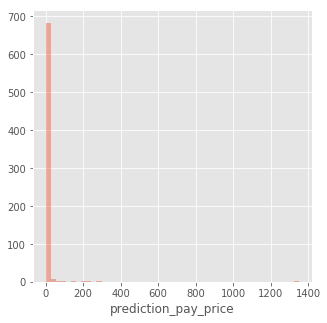

In [46]:
lable3_price = pd.DataFrame(lable3['prediction_pay_price'].value_counts()).sort_index()
plt.figure(figsize=(5,5))
sns.distplot(lable3['prediction_pay_price'].value_counts(), kde=False)

In [9]:
online_time = lable3.iloc[:,105]

In [13]:
online_time2 = StandardScaler().fit_transform(pd.DataFrame(online_time))

In [26]:
dayu370 = lable3[lable3['avg_online_minutes']>=370]
xiaoyu370 = lable3[lable3['avg_online_minutes']<370]

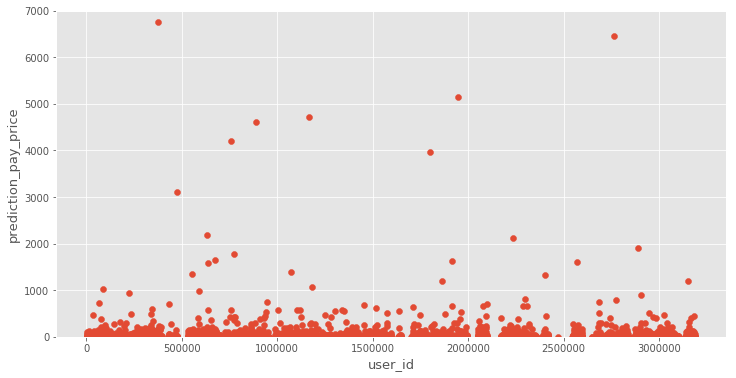

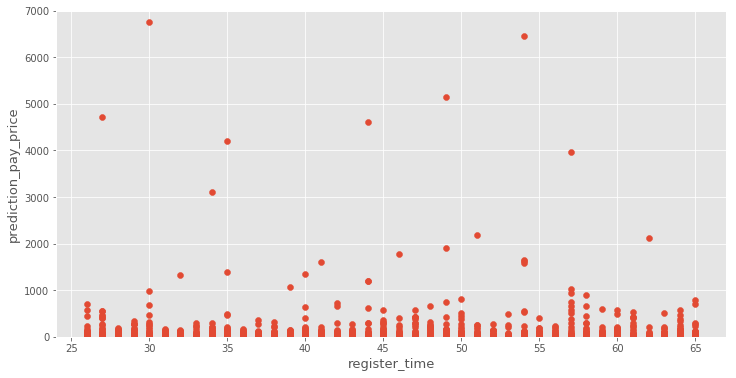

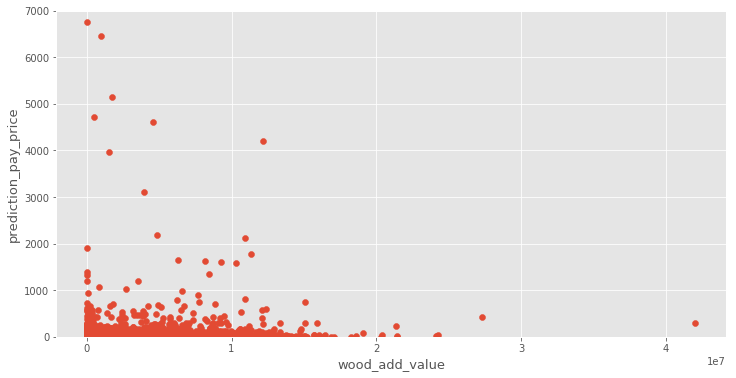

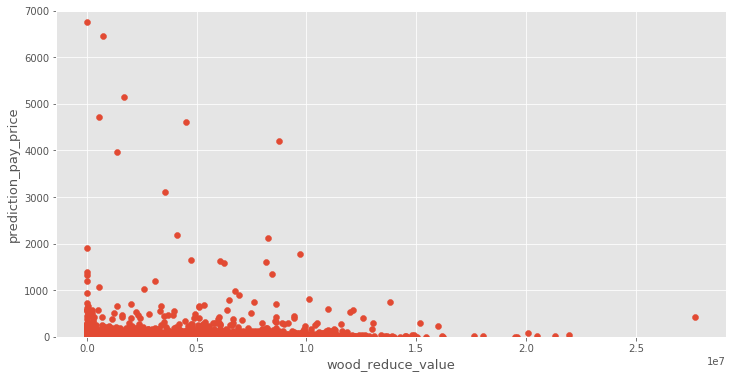

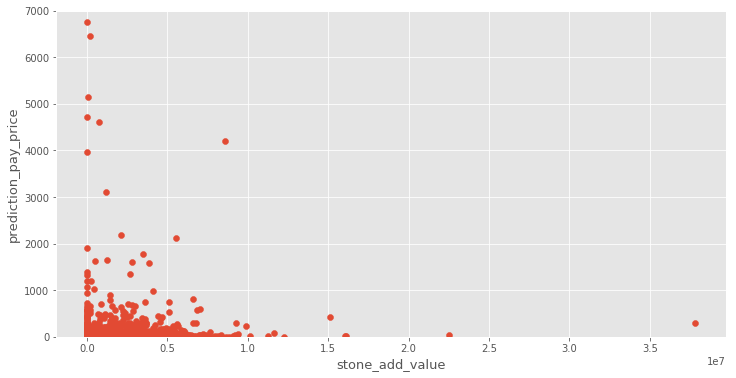

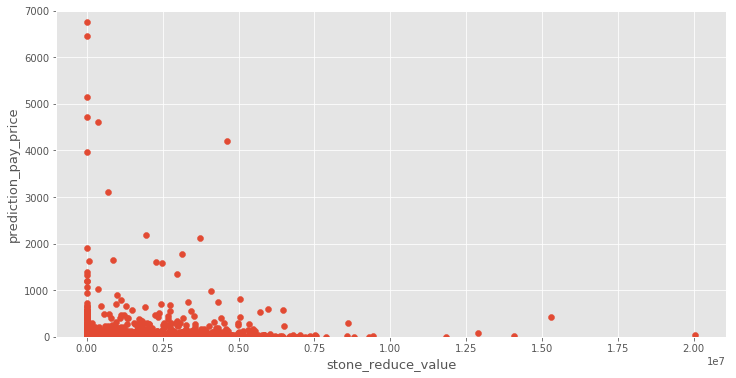

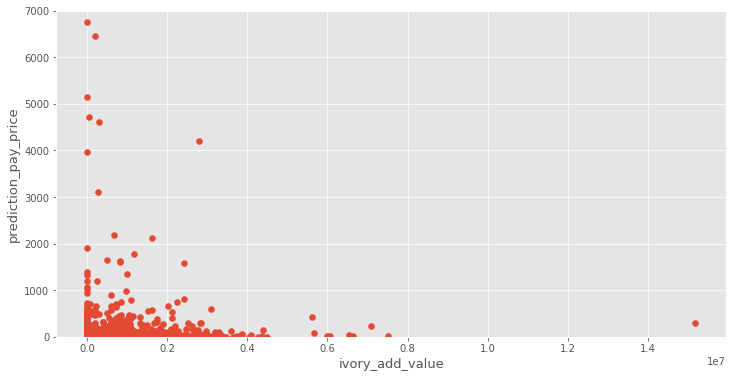

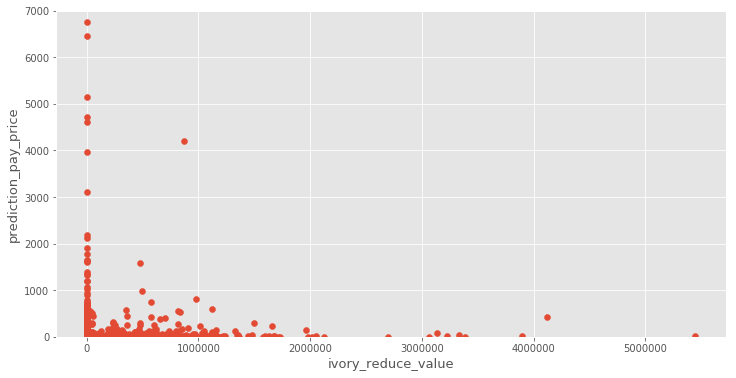

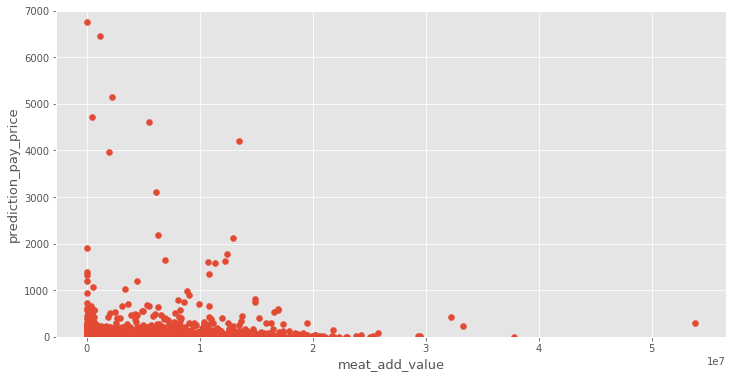

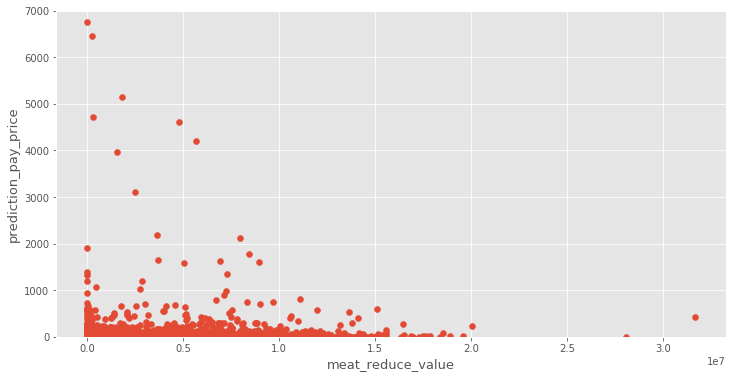

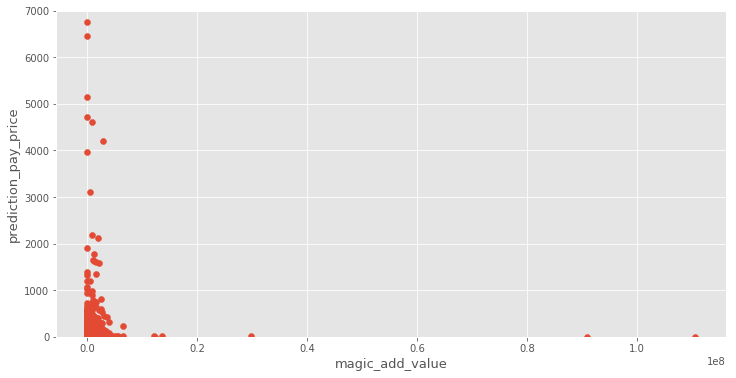

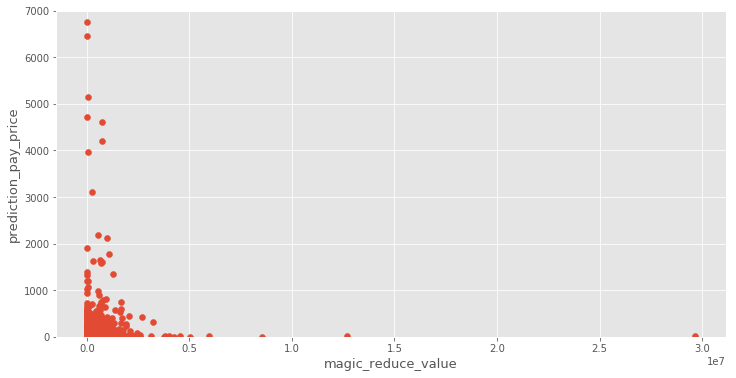

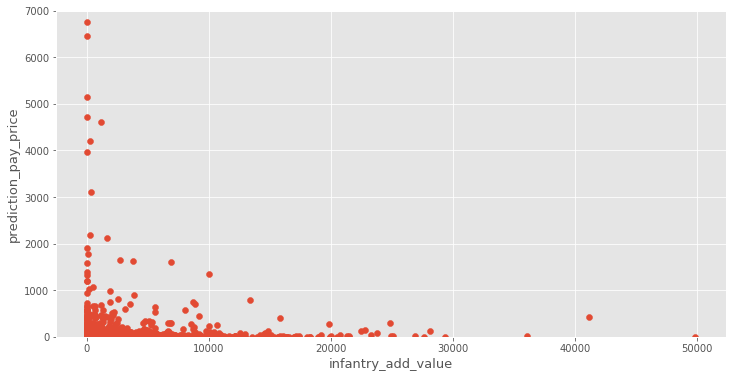

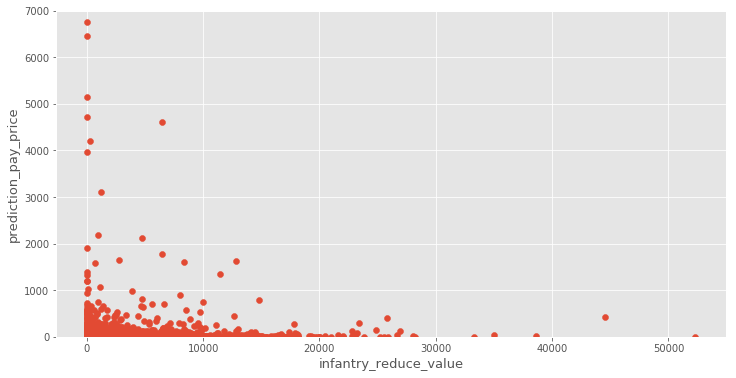

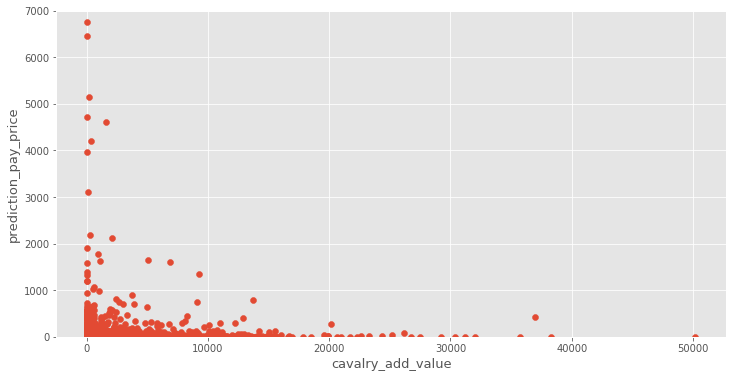

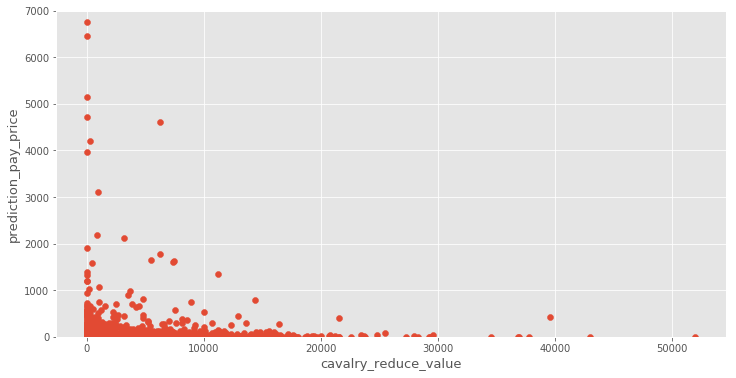

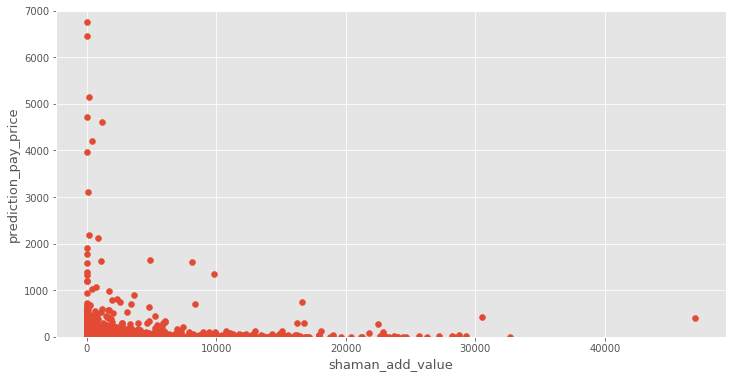

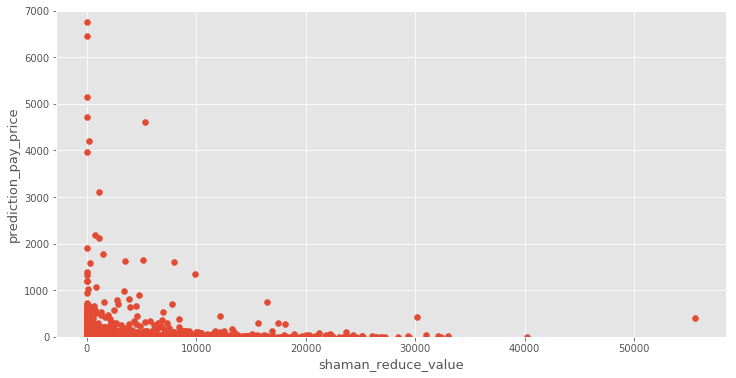

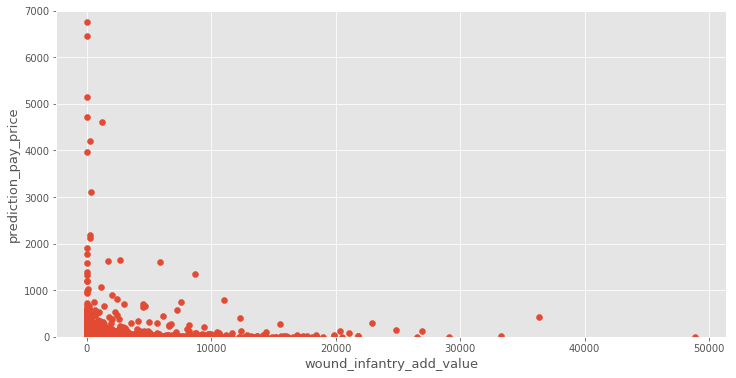

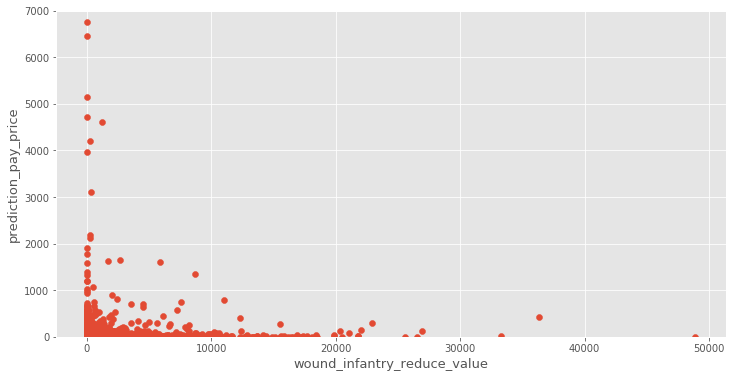

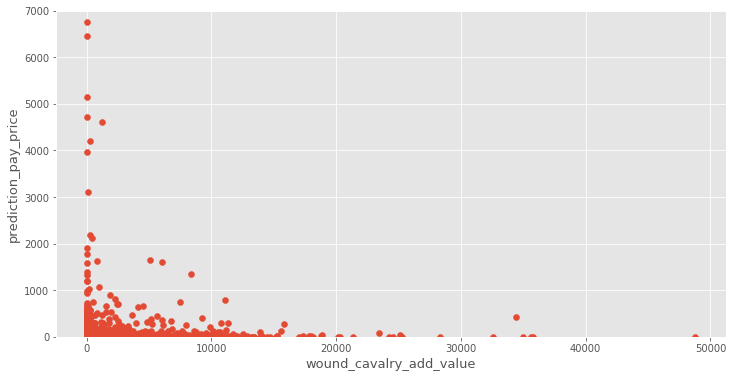

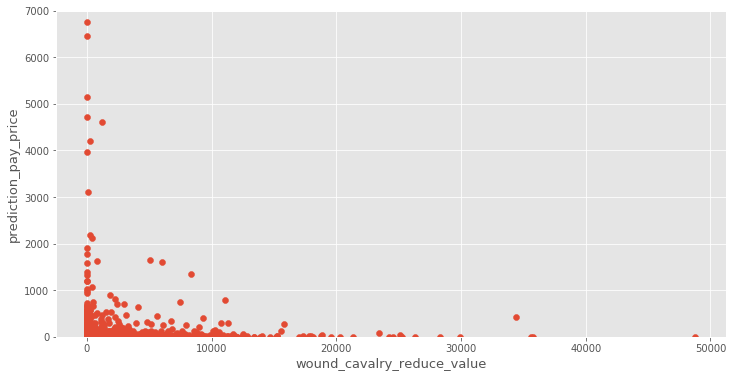

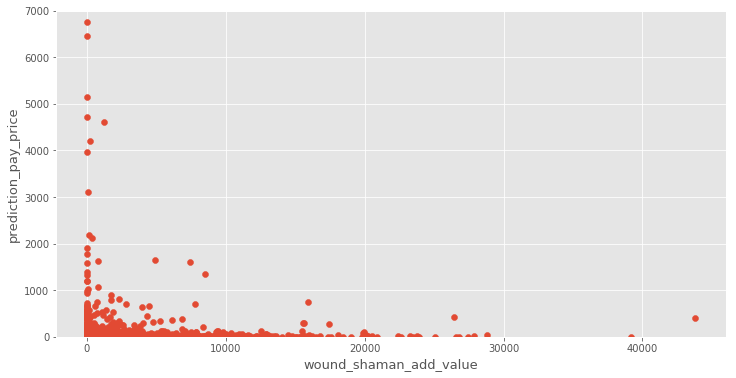

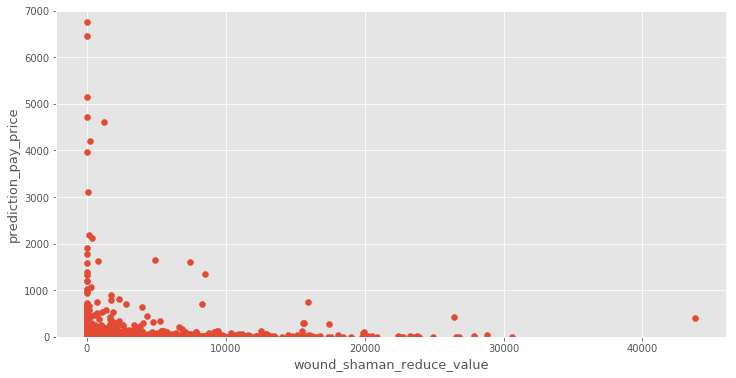

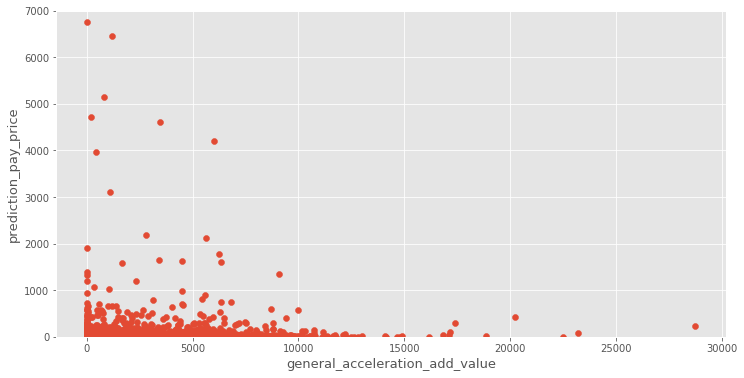

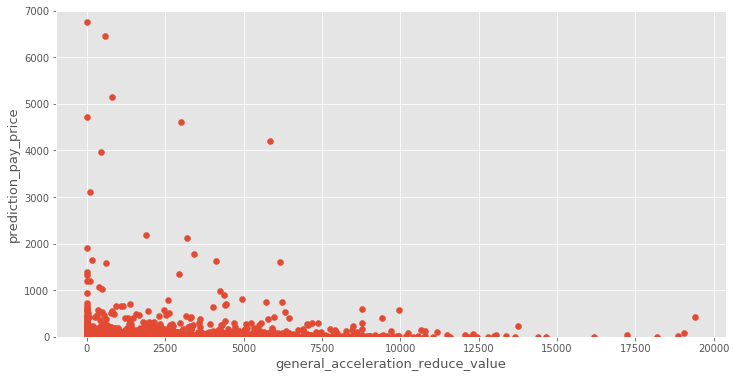

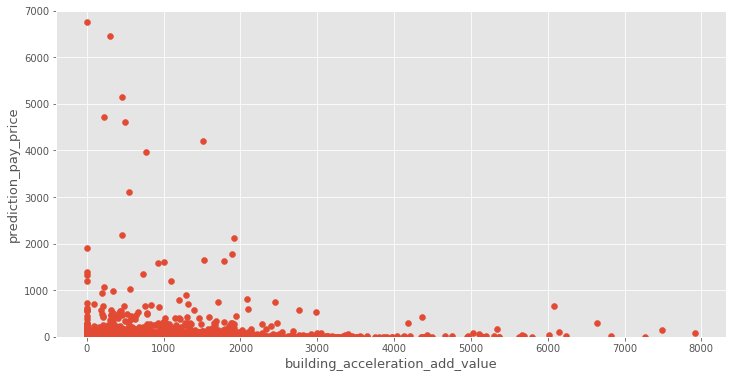

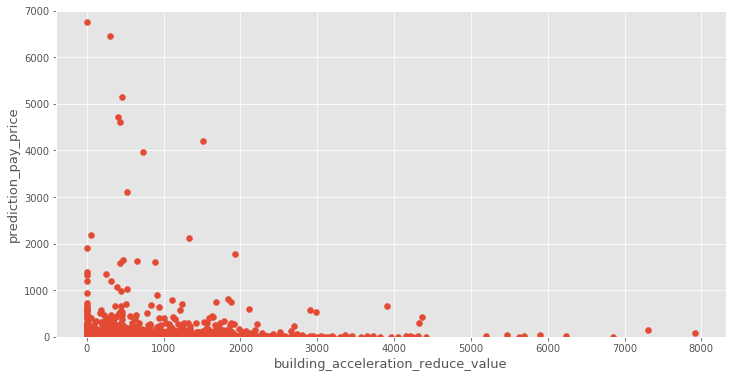

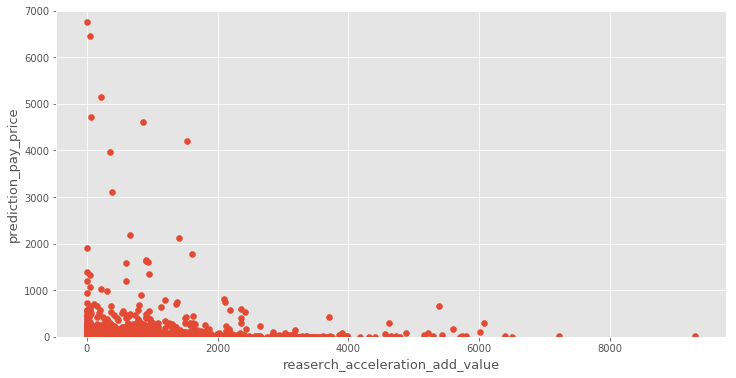

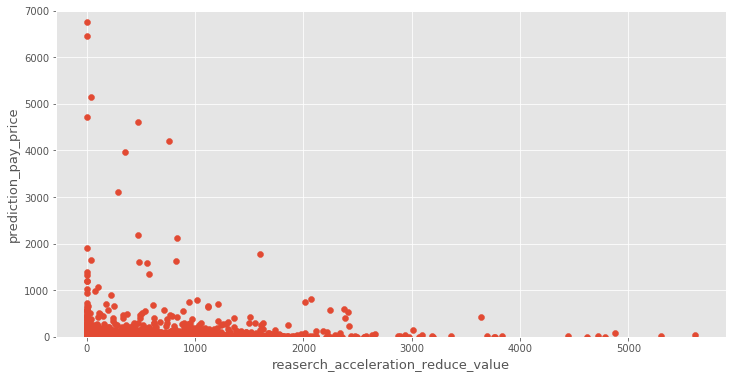

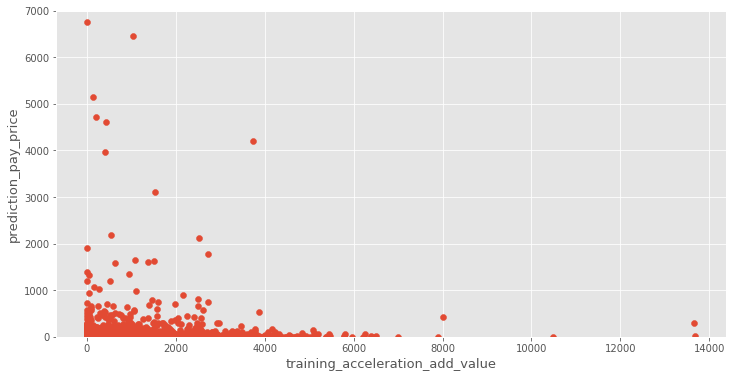

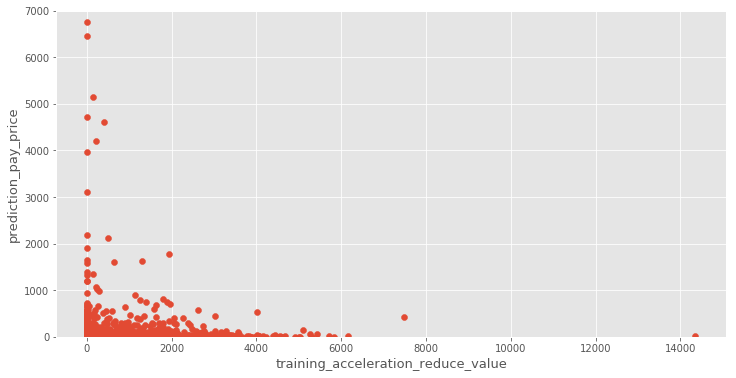

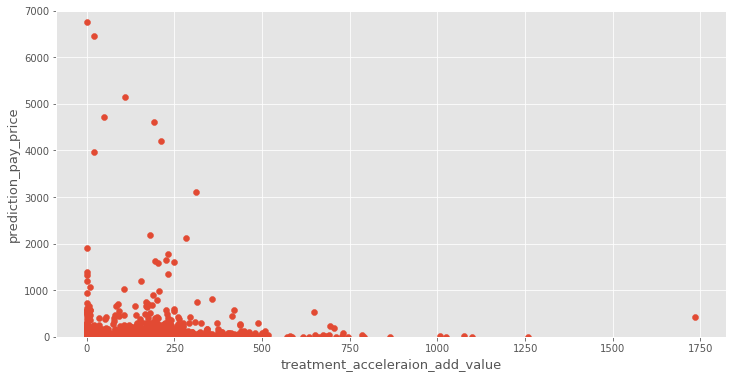

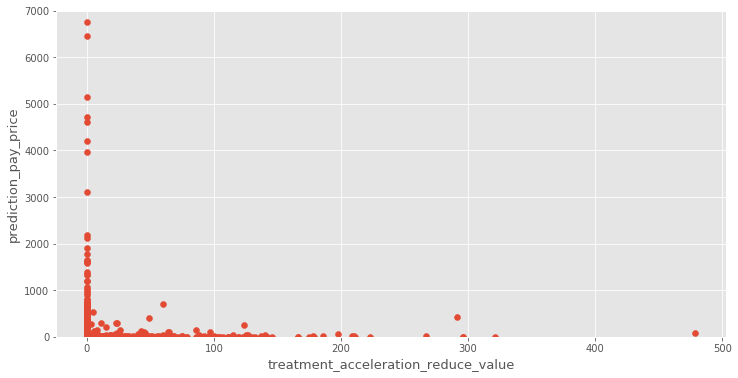

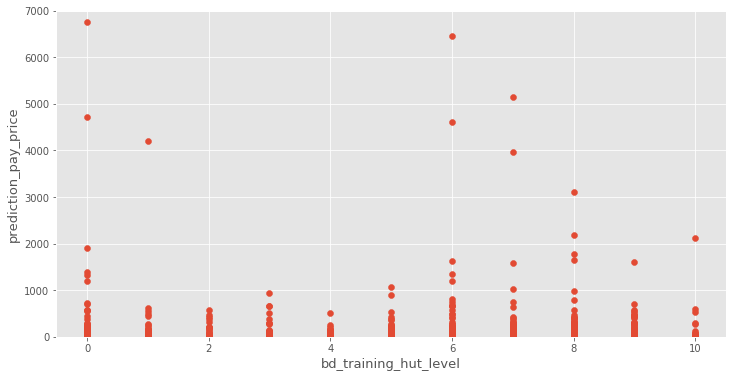

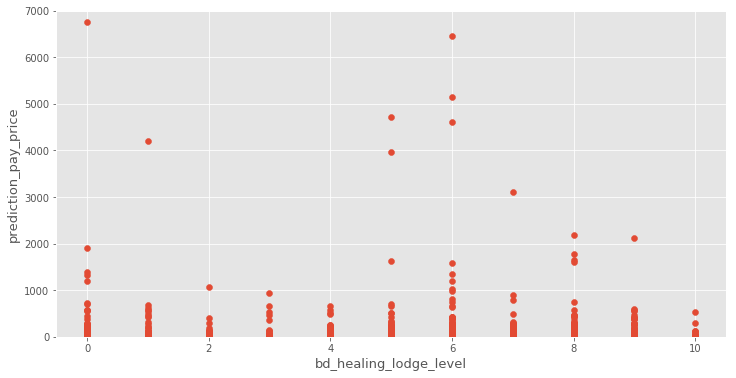

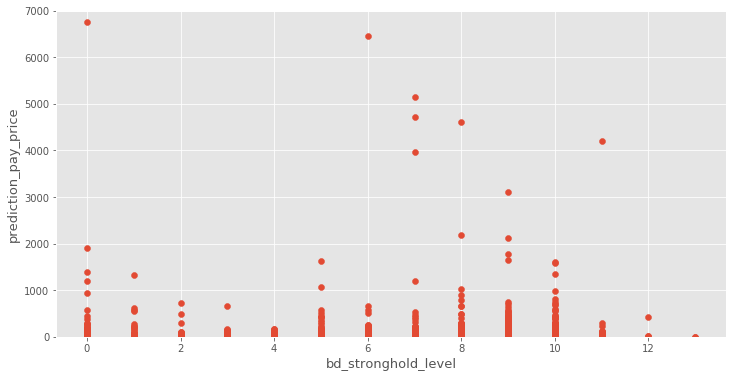

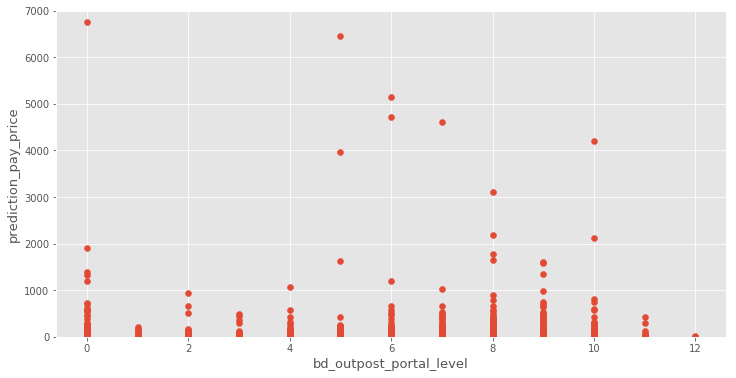

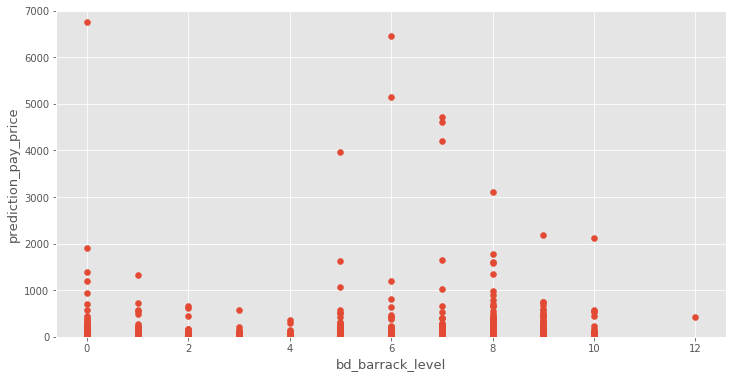

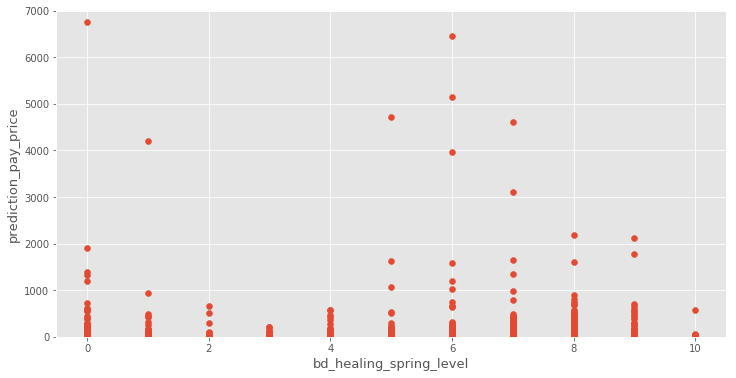

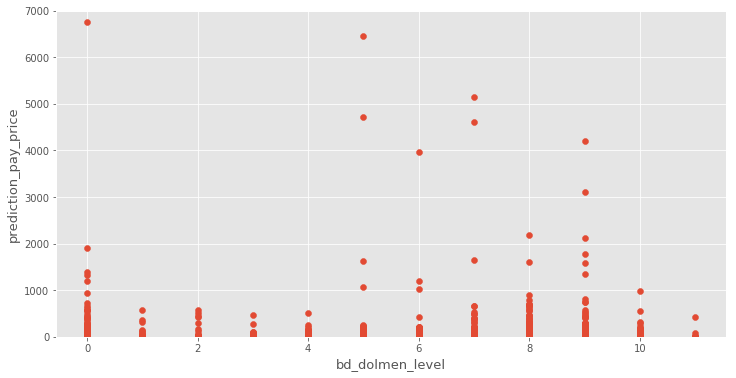

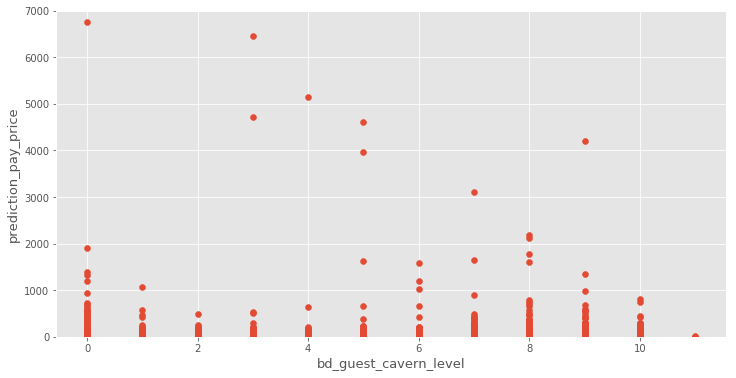

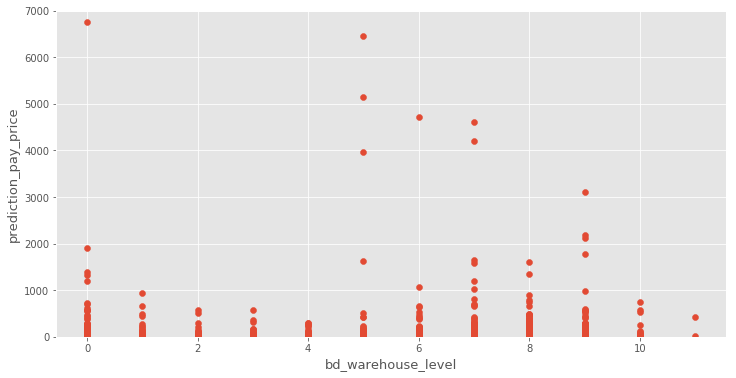

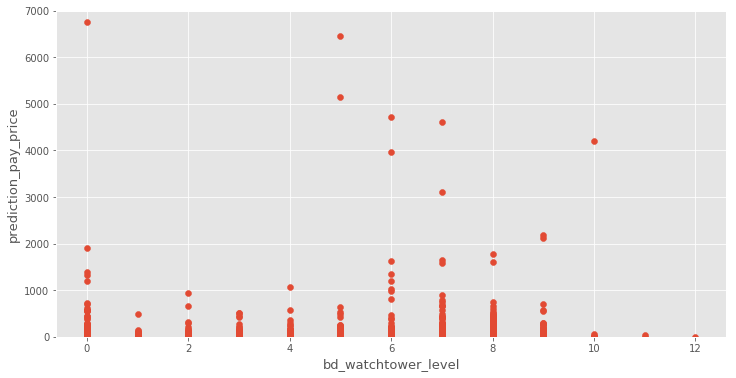

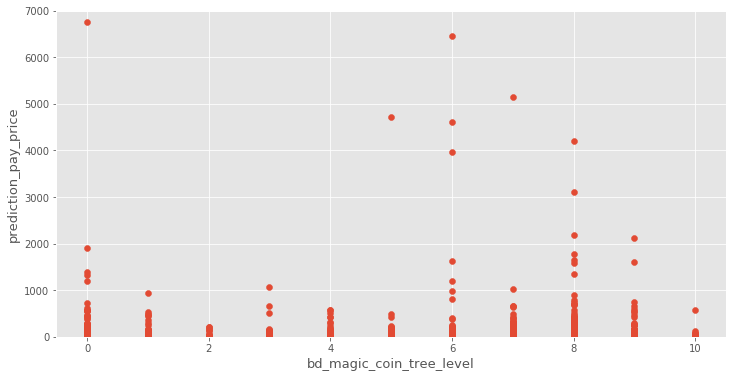

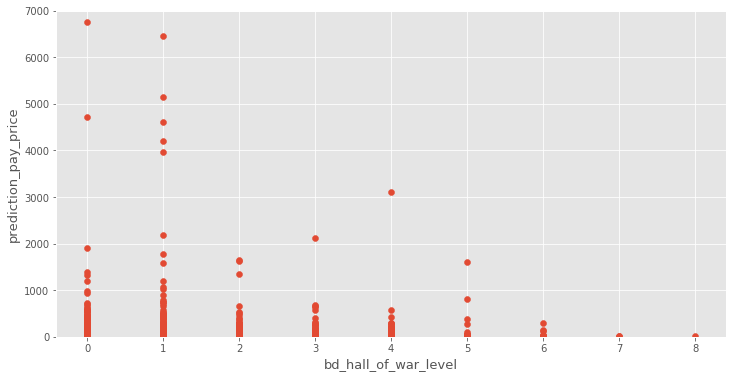

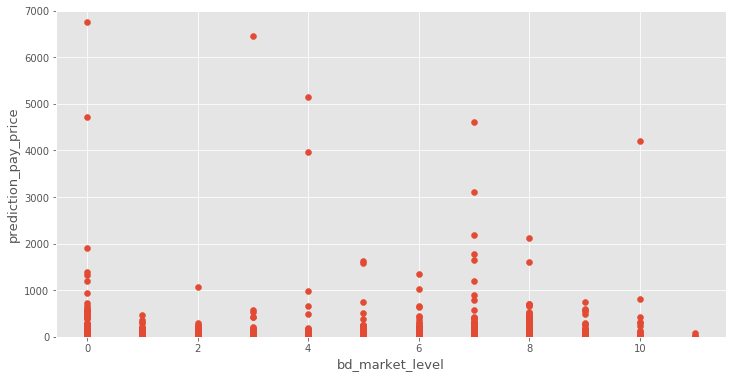

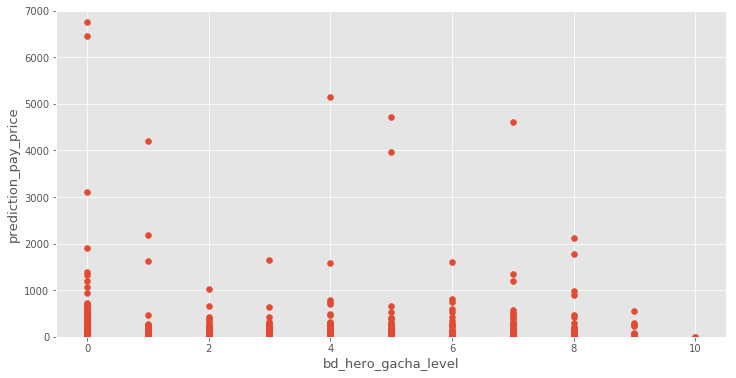

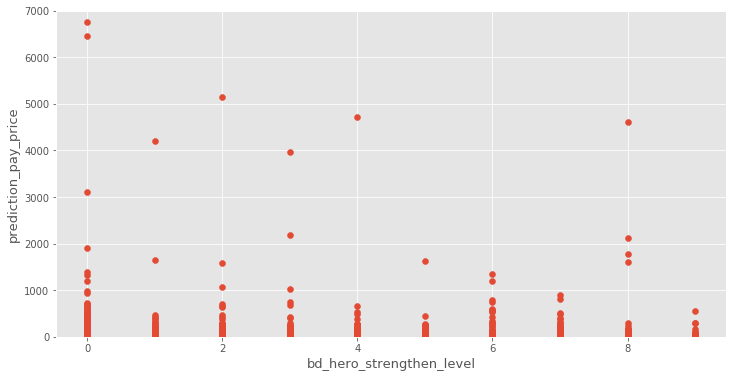

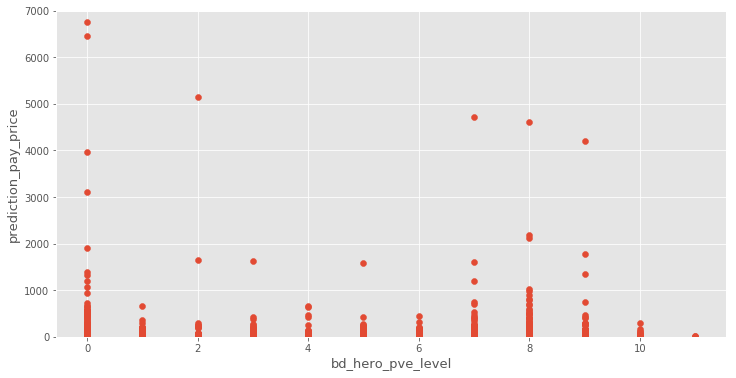

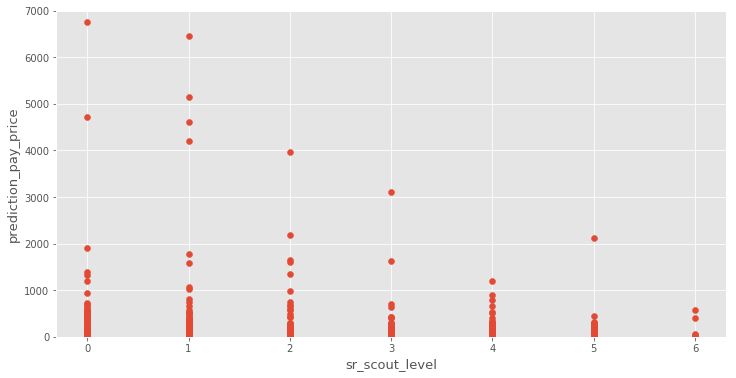

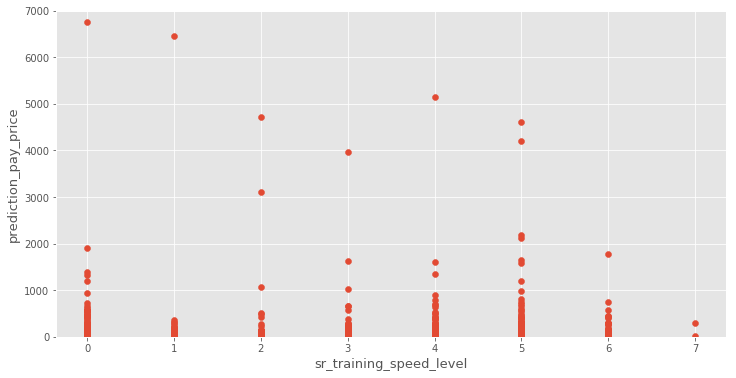

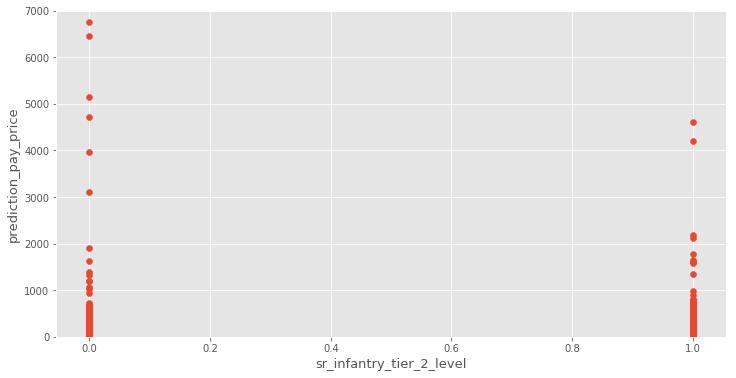

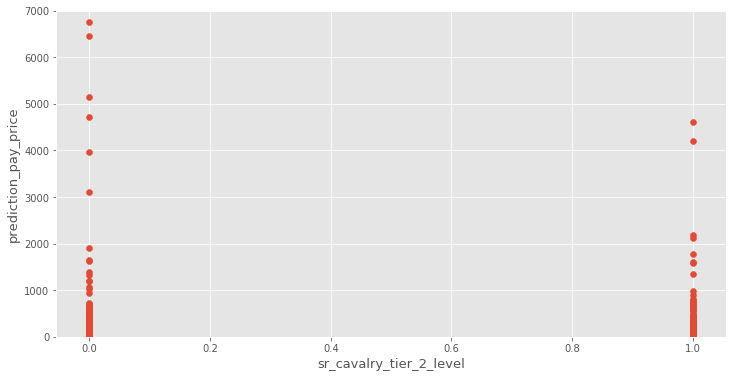

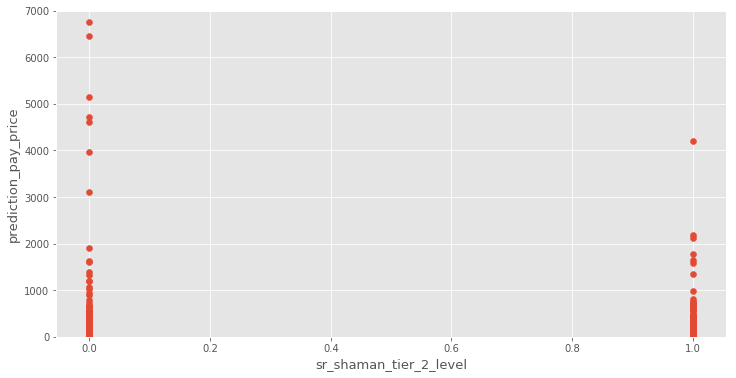

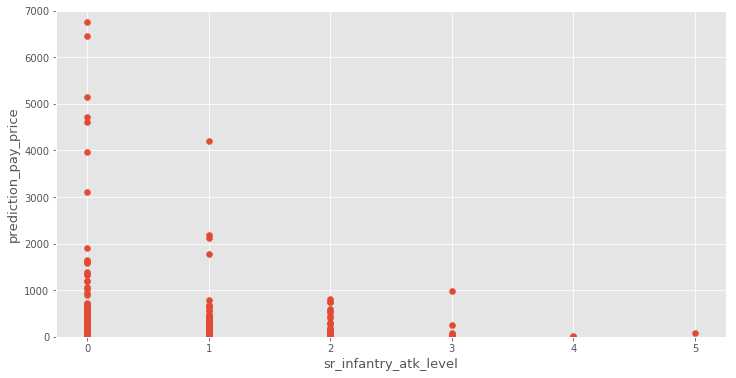

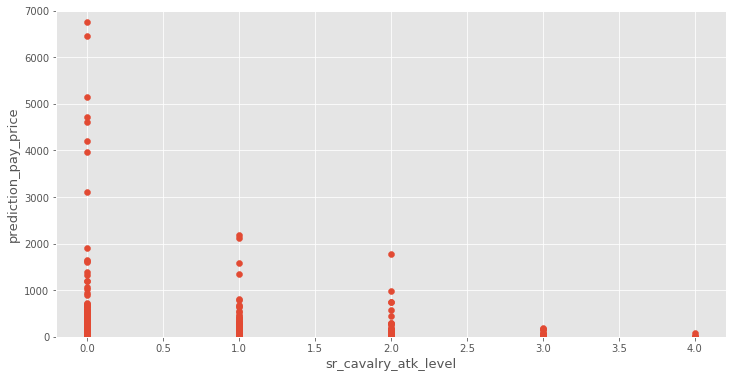

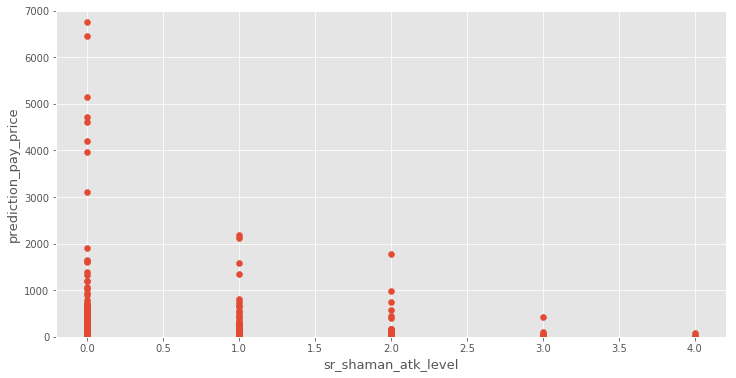

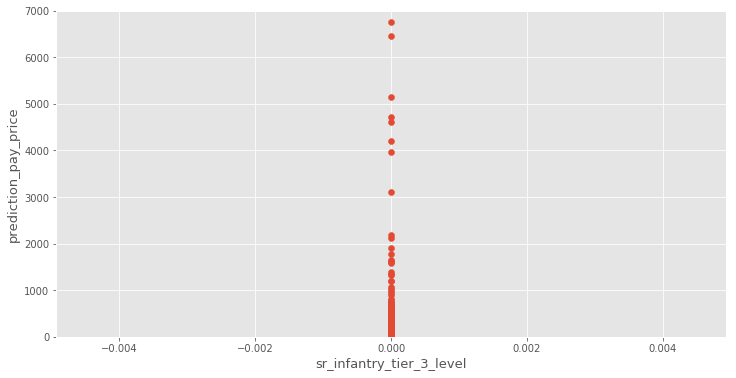

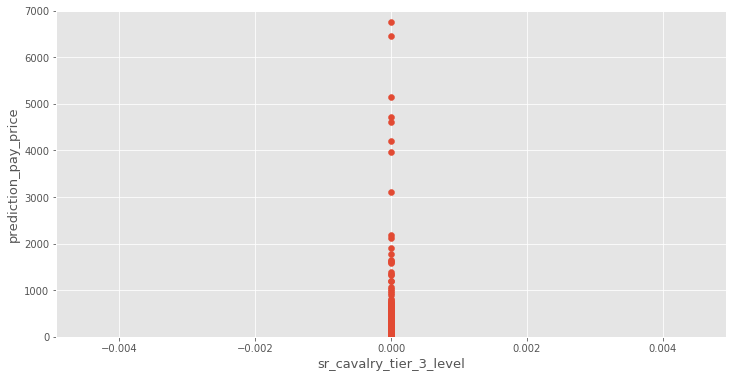

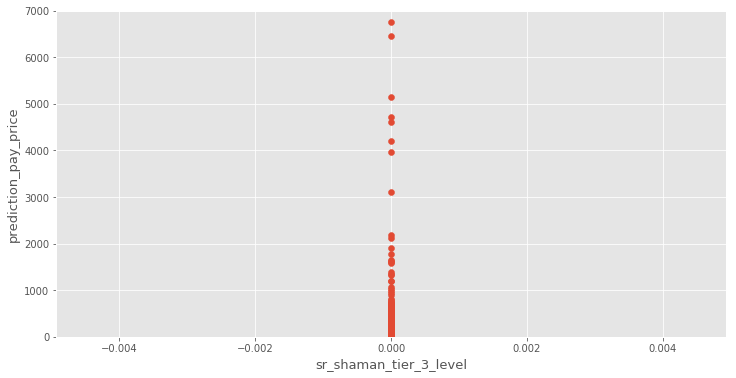

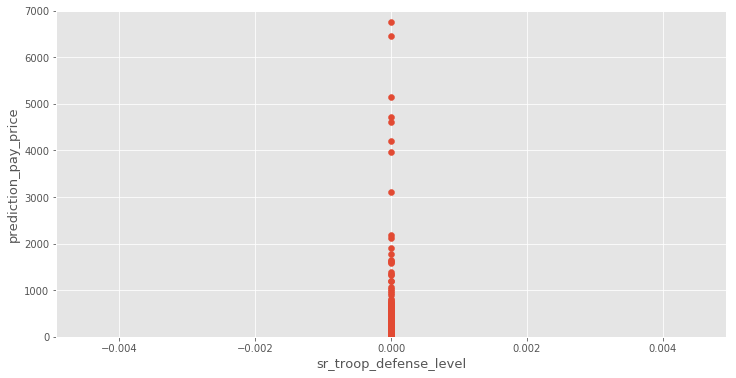

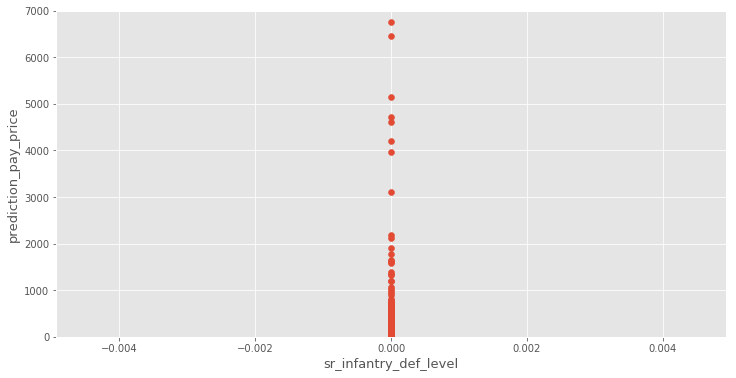

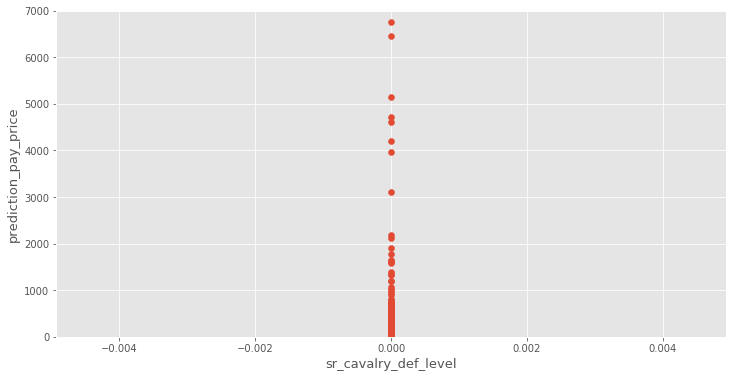

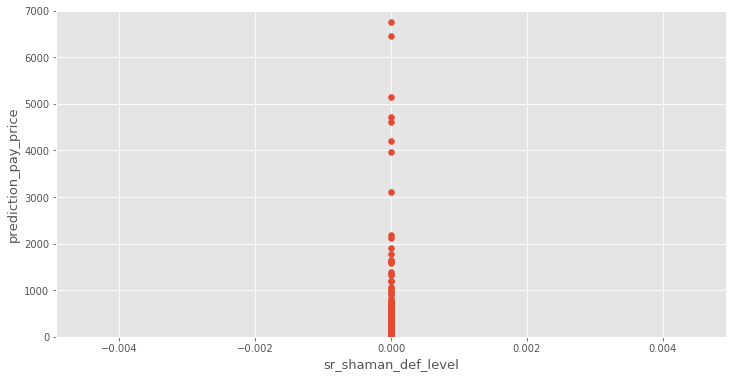

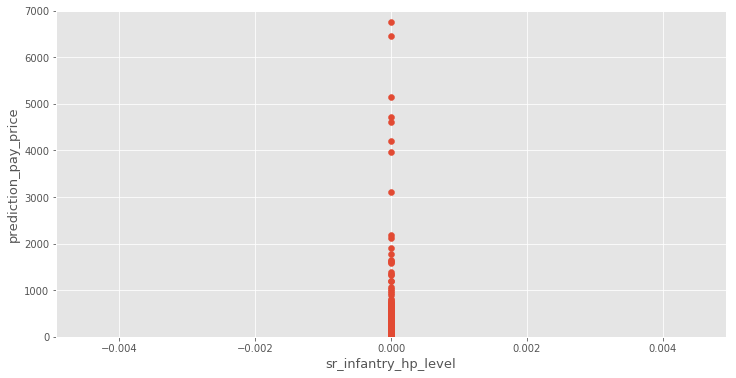

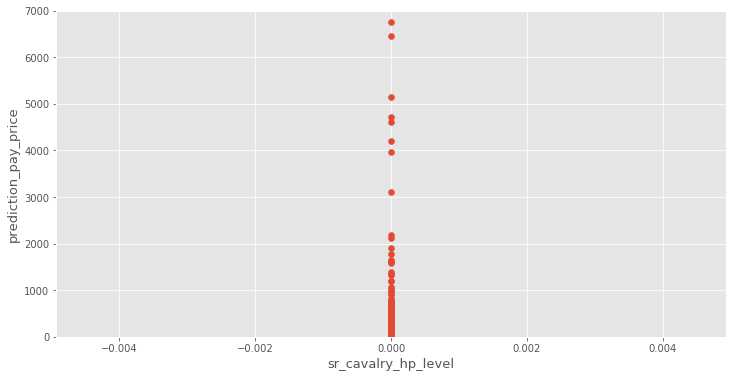

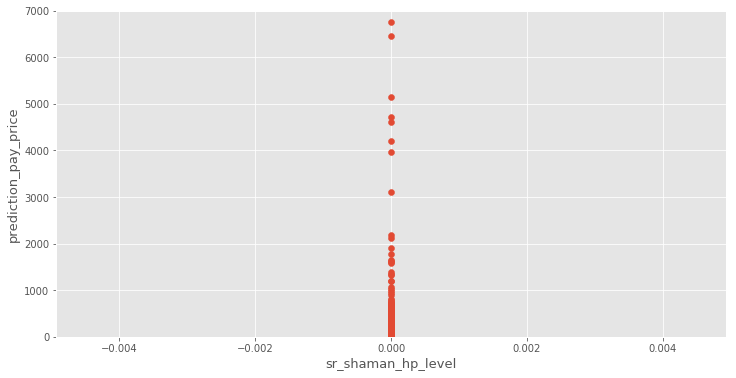

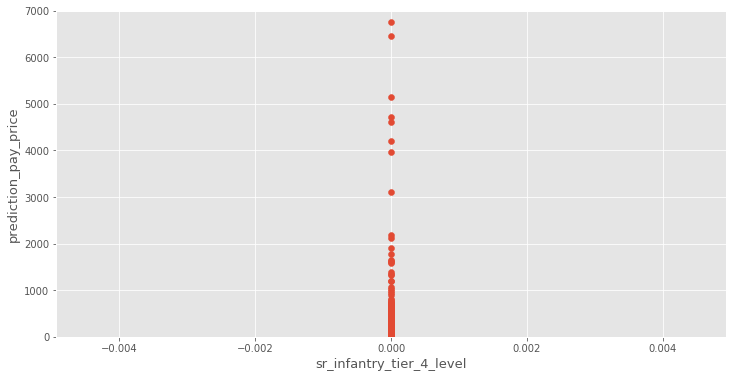

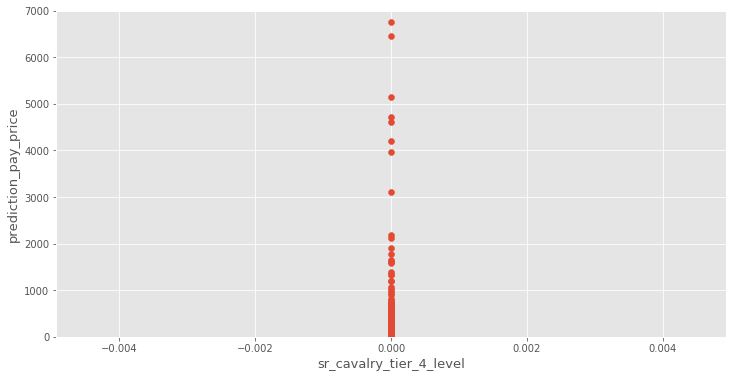

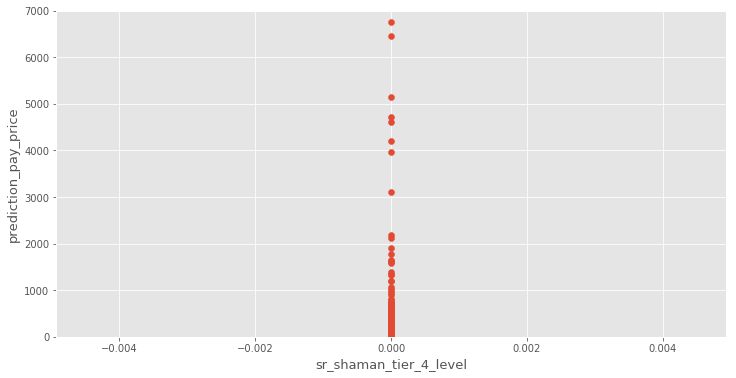

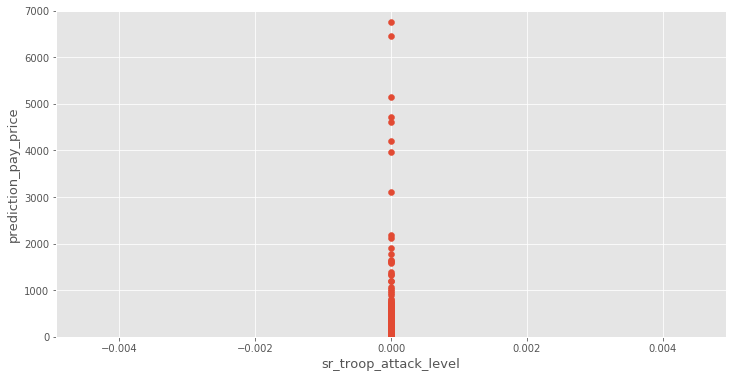

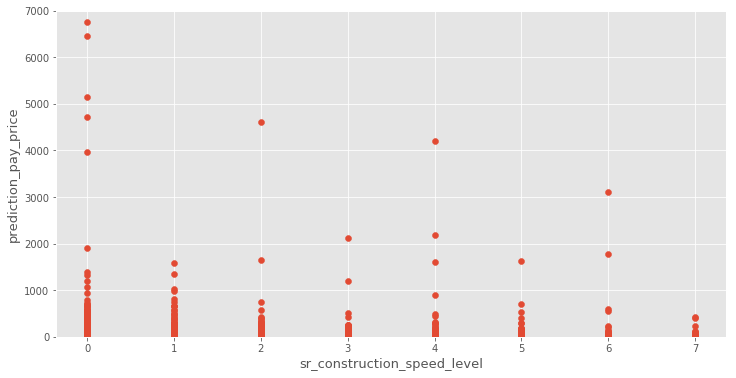

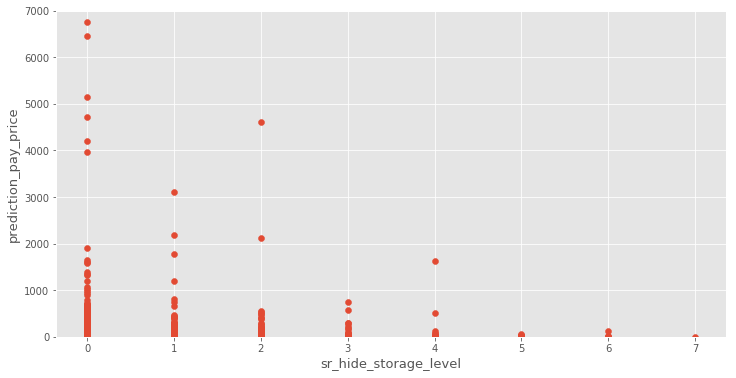

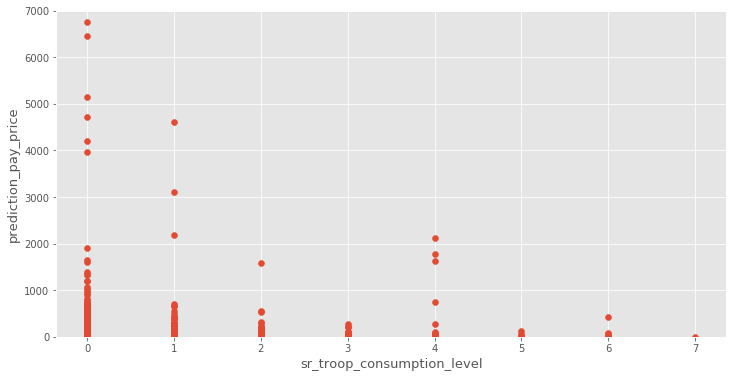

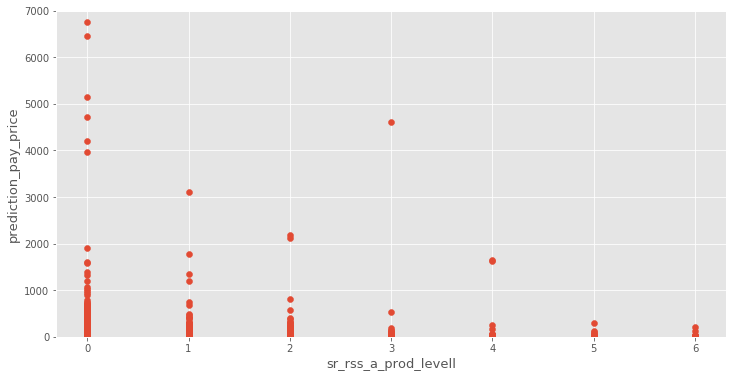

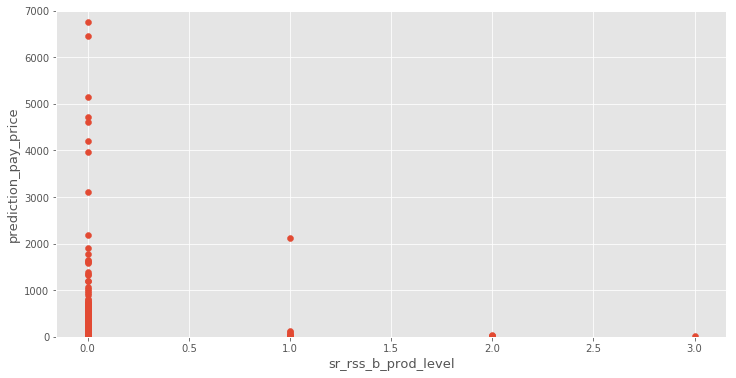

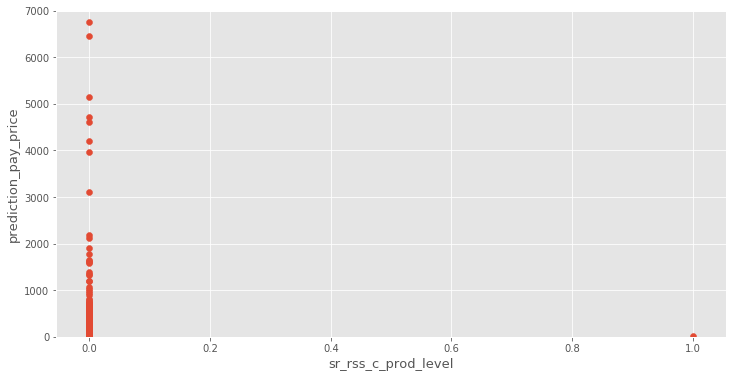

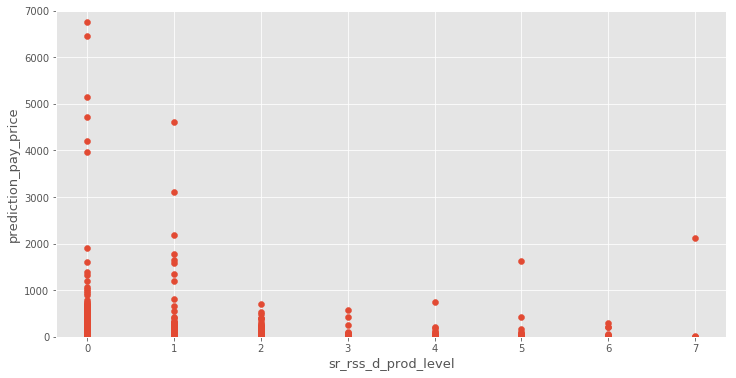

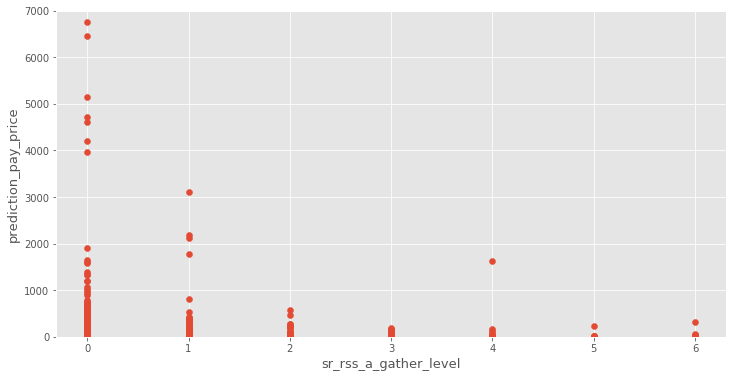

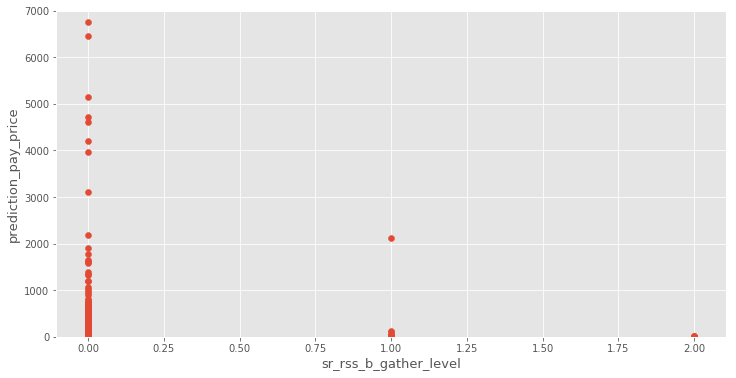

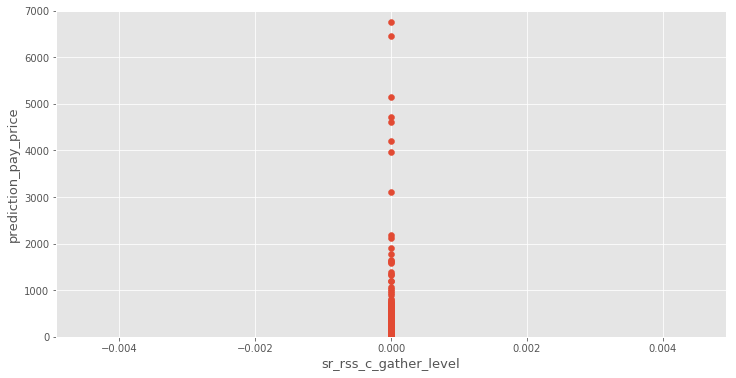

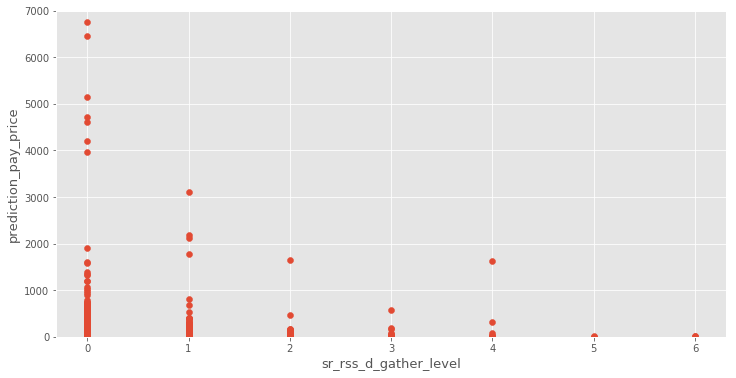

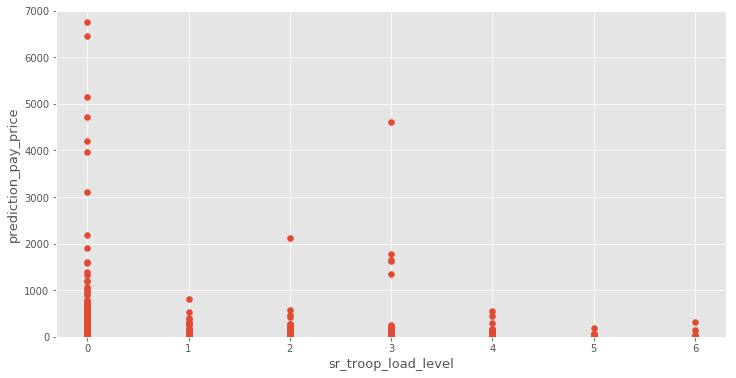

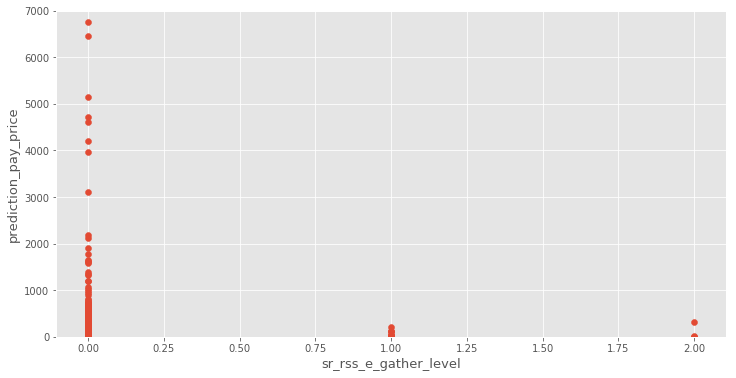

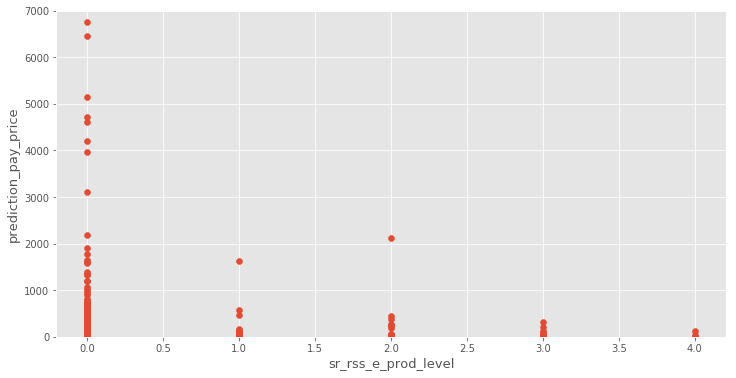

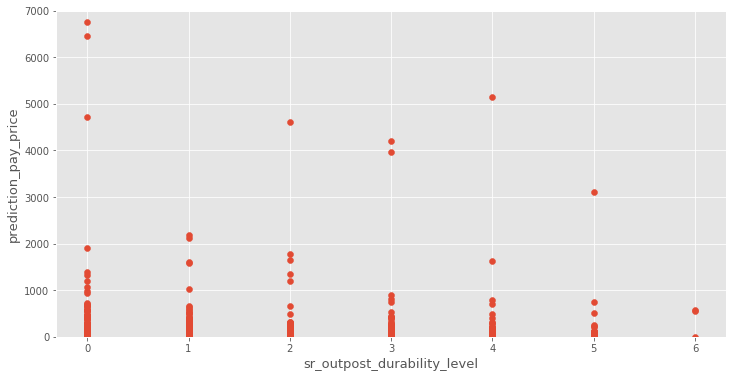

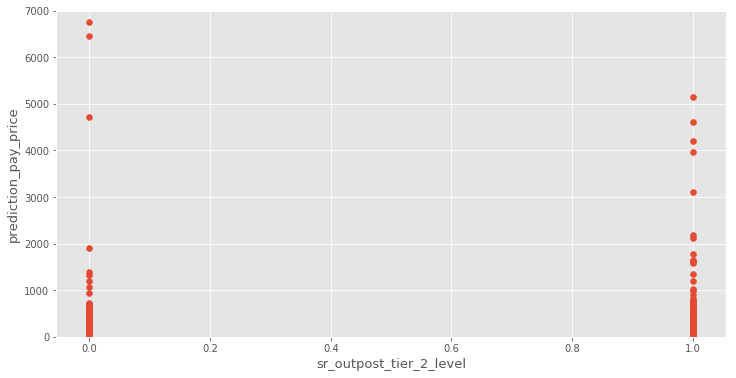

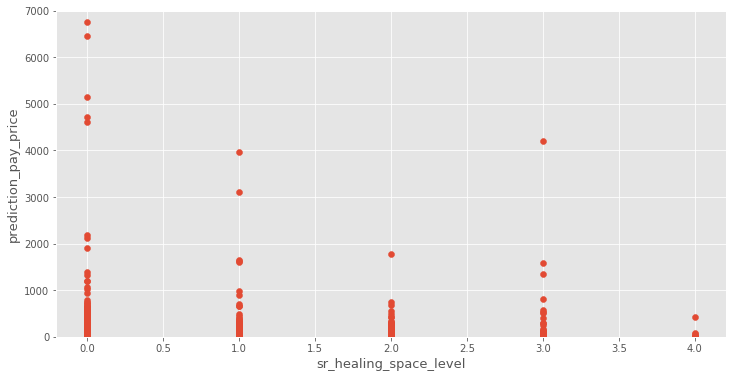

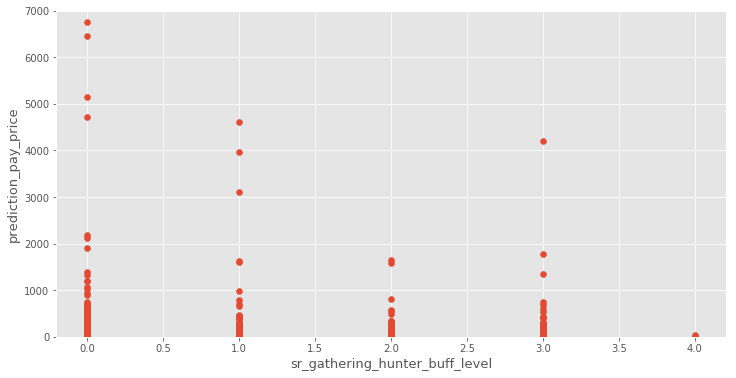

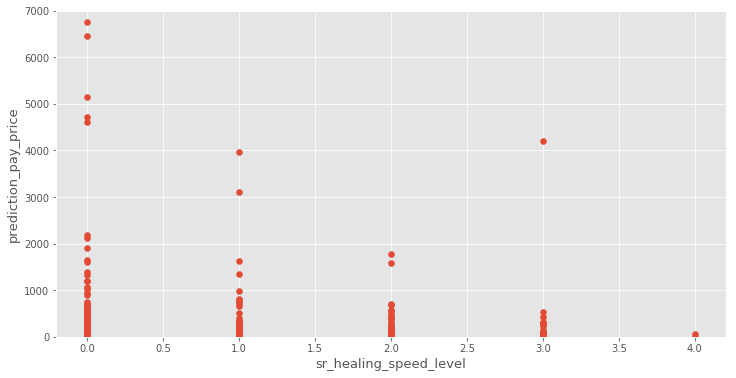

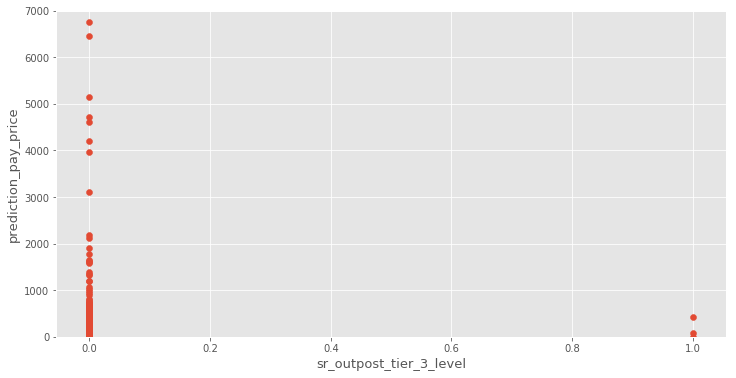

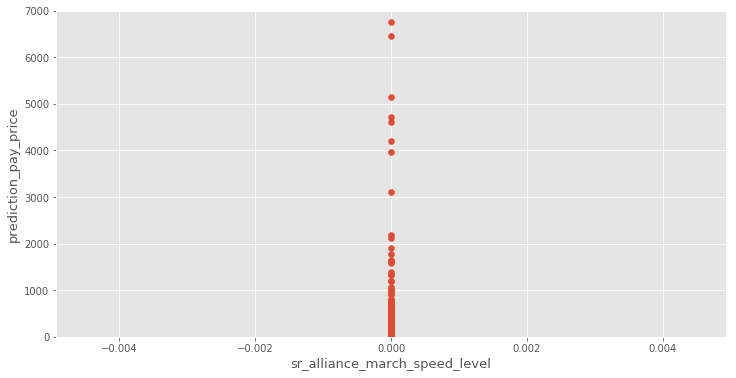

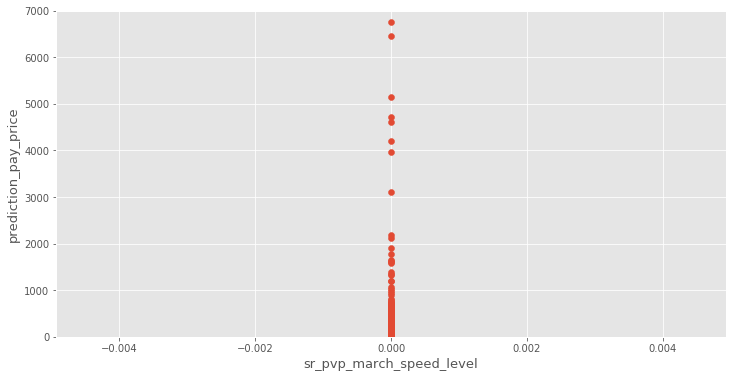

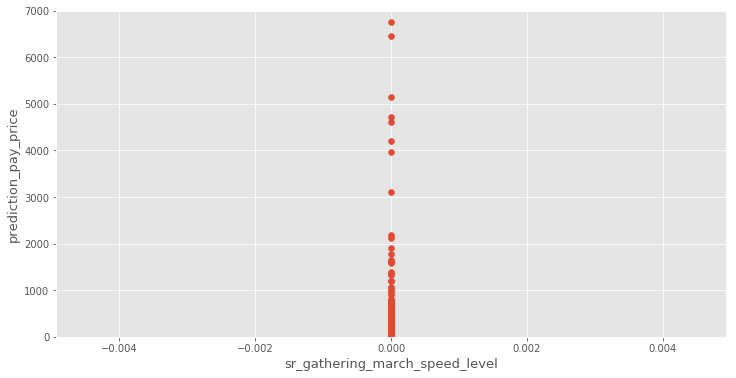

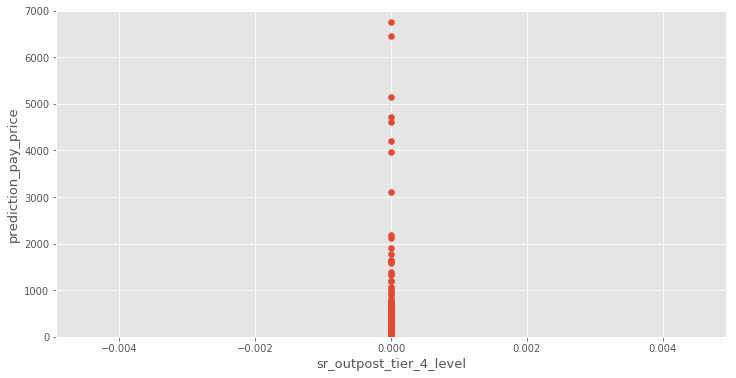

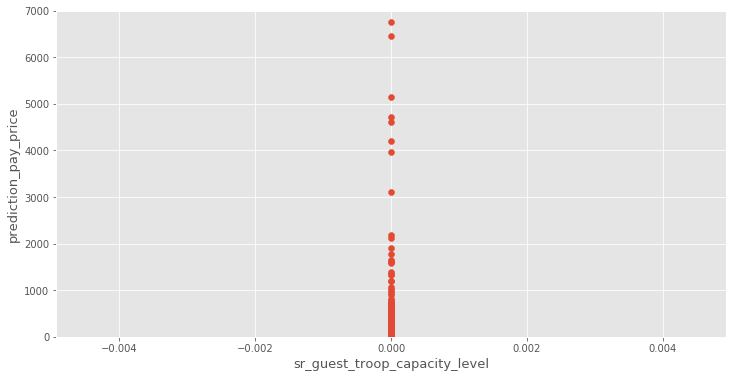

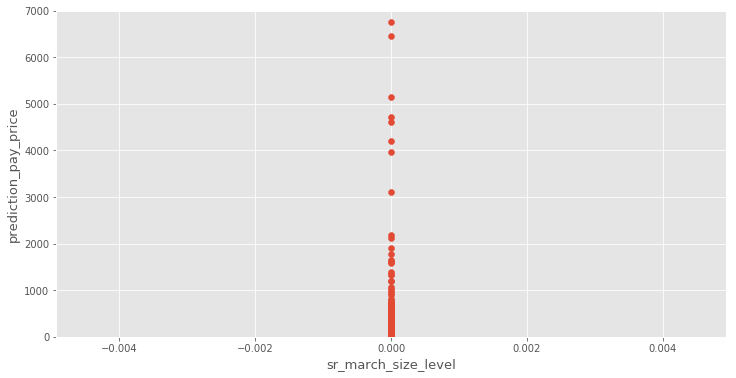

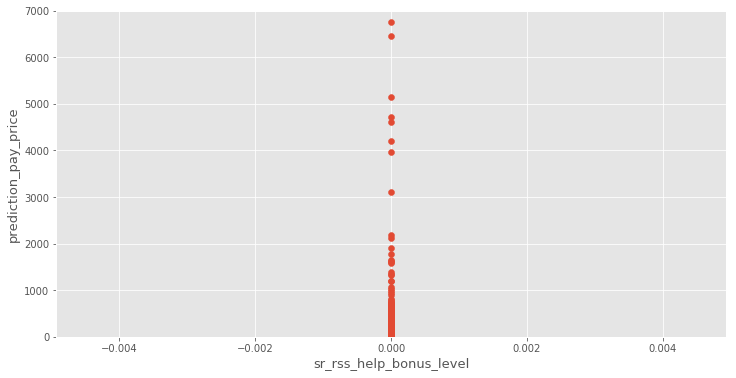

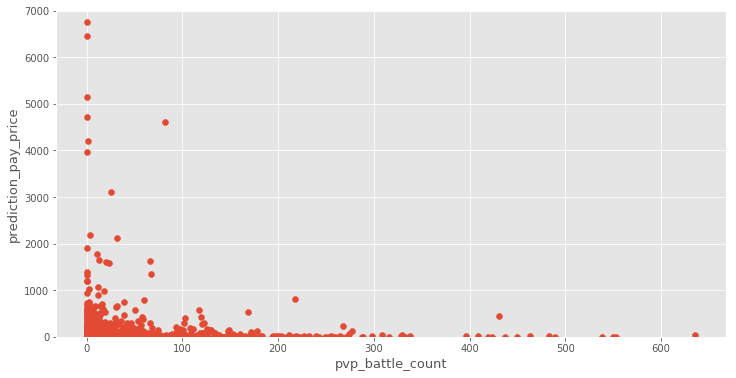

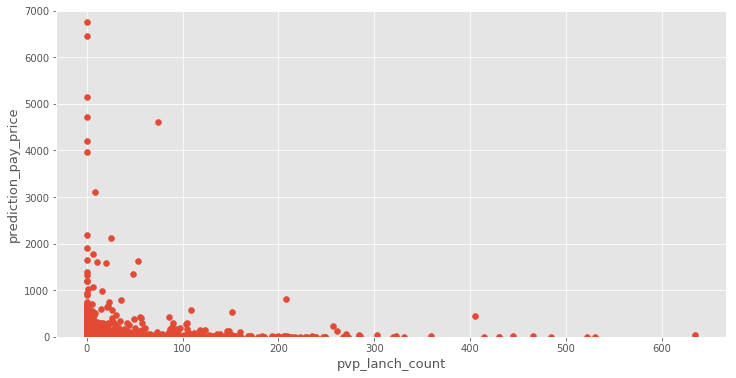

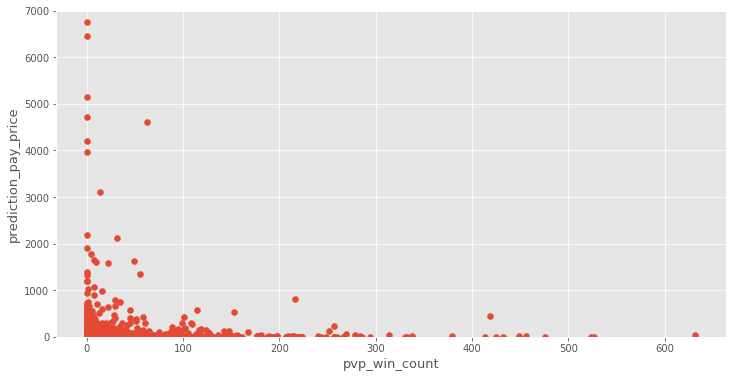

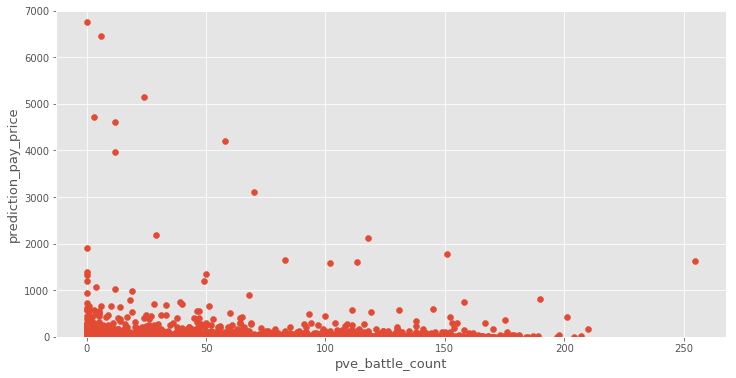

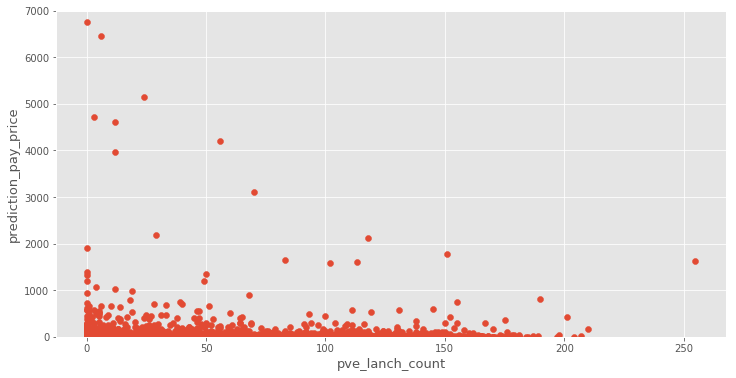

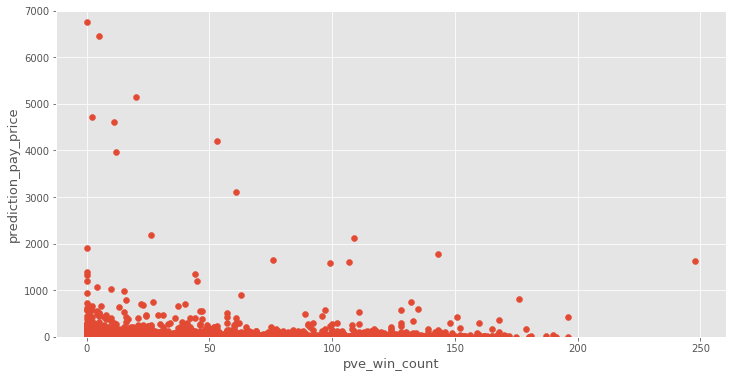

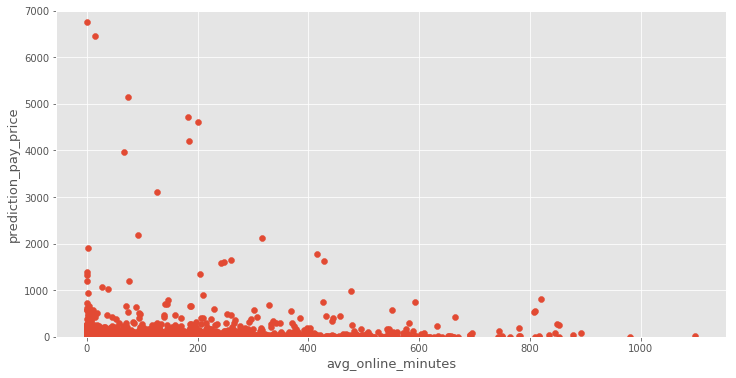

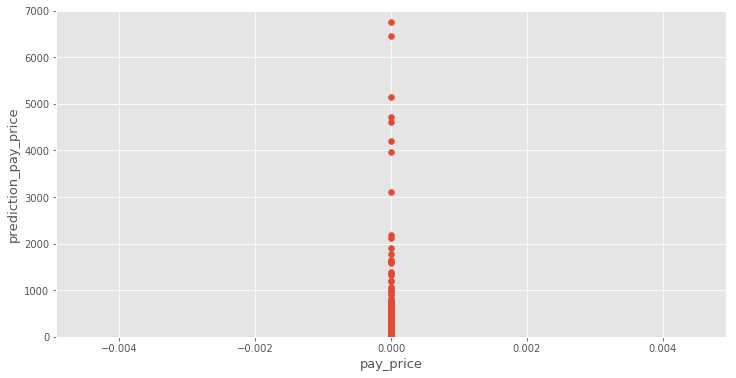

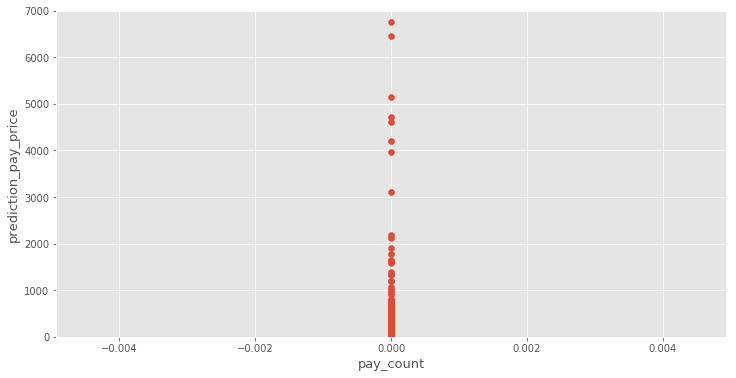

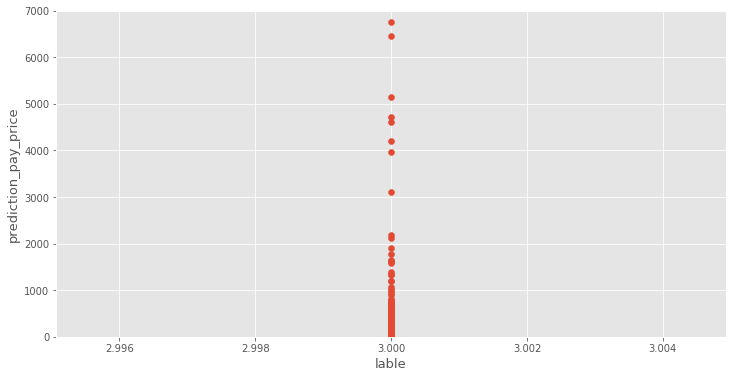

In [31]:
cols = [ x for x in lable3.columns if x not in ['prediction_pay_price']]
for col in cols:
    plt.figure(figsize=(12,6))
    plt.scatter(x=lable3[col], y=lable3.prediction_pay_price)
    plt.xlabel(col, fontsize=13)
    plt.ylabel("prediction_pay_price", fontsize=13)
    plt.ylim(0,7000)
    plt.show()


(0, 10000)

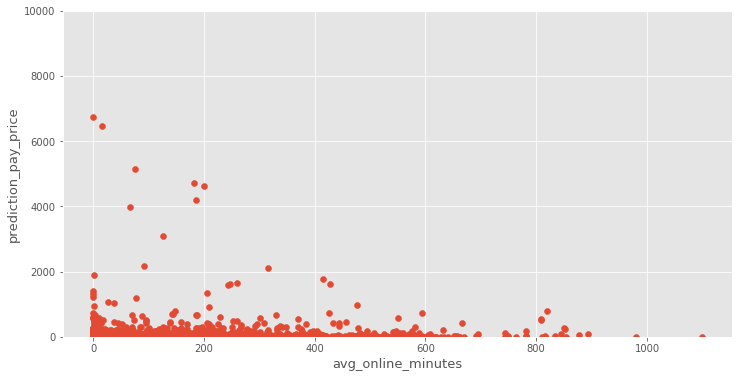

In [34]:
plt.figure(figsize=(12,6))
plt.scatter(x=lable3.avg_online_minutes, y=lable3.prediction_pay_price)
plt.xlabel("avg_online_minutes", fontsize=13)
plt.ylabel("prediction_pay_price", fontsize=13)
plt.ylim(0,10000)

In [3]:
class add_feature_time(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):    
        print "add_feature_time"
        dt1=pd.to_datetime(X["register_time"])
        X["register_time"] = dt1
        X["wkd"] = dt1.dt.weekday
        X["day"] = dt1.dt.day
        X["hour"] = dt1.dt.hour
        X["day_in_year"] = dt1.dt.dayofyear
        X["days_spfest"] = X["register_time"].map(lambda x: (x - pd.to_datetime("2018-02-16")).days)

        X = X.drop(["register_time"],axis=1)
        
        return X

In [4]:
class add_feature_price_per(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):    
        print "add_feature_price_per"
        if "register_time" in X.columns:
            X = X.drop("register_time",axis=1)
        X["price_per"] = (X["pay_price"]+0.1)/(X["pay_count"]+0.1)
        X["avg_pay_price"] = X.pay_price/(X.avg_online_minutes+0.01)
        X["avg_pay_count"] = X.pay_count/(X.avg_online_minutes+0.01)
        X.loc[X.avg_online_minutes == 0,"avg_pay_price"] = 0
        X.loc[X.avg_online_minutes == 0,"avg_pay_count"] = 0

        return X

In [5]:
class add_feature_win(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):    
        print "add_feature_win"
        if "register_time" in X.columns:
            X = X.drop("register_time",axis=1)

        X["pvp_win_rate"] = (X.pvp_win_count + 0.1)/(X.pvp_lanch_count+0.1)
        X["pve_win_rate"] = (X.pve_win_count+0.1)/(X.pve_lanch_count+0.1)
        X["pvp_rate"] = (X.pvp_lanch_count+0.1)/(X.pve_lanch_count+0.1)
        X["pvp_vs_pve_win"] = (X.pvp_win_count+0.1)/(X.pve_win_count+0.1)
        X["pve_vs_price"] = X["pve_win_count"]/(X["pay_price"]+0.1)
        X["pvp_vs_price"] = X["pvp_win_count"]/(X["pay_price"]+0.1)
        X["avg_pay_price"] = X.pay_price/(X.avg_online_minutes+0.01)
        X["avg_pay_count"] = X.pay_count/(X.avg_online_minutes+0.01)
        X.loc[X.avg_online_minutes == 0,"avg_pay_price"] = 0
        X.loc[X.avg_online_minutes == 0,"avg_pay_count"] = 0
        
        return X

In [6]:
class add_feature_resource(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):
        print "add_feature_resource"
        if "register_time" in X.columns:
            X = X.drop("register_time",axis=1)
        
        X['wood'] = X['wood_add_value'] - X['wood_reduce_value'] 
        X['stone'] = X['stone_add_value'] - X['stone_reduce_value'] 
        X['ivory'] = X['ivory_add_value']  - X['ivory_reduce_value'] 
        X['meat'] =  X['meat_add_value'] - X['meat_reduce_value']
        X['magic'] =  X['magic_add_value'] - X['magic_reduce_value']
        
        return X

In [7]:
class add_feature_acceleration(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):
        print "add_feature_acceleration"
        if "register_time" in X.columns:
            X = X.drop("register_time",axis=1)
        X['general_acceleration'] = X['general_acceleration_reduce_value'] - X['general_acceleration_add_value'] 
        X['building_acceleration'] = X['building_acceleration_add_value'] - X['building_acceleration_reduce_value']
        X['reaserch_acceleration'] = X['reaserch_acceleration_add_value'] -  X['reaserch_acceleration_reduce_value']
        X['training_acceleration'] =  X['training_acceleration_add_value'] - X['training_acceleration_reduce_value']
        X['treatment_acceleration'] =  X['treatment_acceleraion_add_value'] - X['treatment_acceleration_reduce_value'] 
        X["build_remain"] = X.building_acceleration_add_value - X.building_acceleration_reduce_value
        X["build_use_rate"] = (X.building_acceleration_reduce_value + 0.1)/(X.building_acceleration_add_value + 0.1)
        X["treat_remain"] = X.treatment_acceleraion_add_value - X.treatment_acceleration_reduce_value
        X["treat_use_rate"] = (X.treatment_acceleration_reduce_value+0.1)/(X.treatment_acceleraion_add_value+0.1)
        X["res_remain"] = X.reaserch_acceleration_add_value - X.reaserch_acceleration_reduce_value
        X["res_use_rate"] = (X.reaserch_acceleration_reduce_value+ 0.1)/(X.reaserch_acceleration_add_value+ 0.1)
        return X

In [8]:
class add_feature_shibing(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):
        print "add_feature_shibing"
        if "register_time" in X.columns:
            X = X.drop("register_time",axis=1)
        X['infantry'] = X['infantry_add_value'] - X['infantry_reduce_value'] 
        X['cavalry'] = X['cavalry_add_value'] - X['cavalry_reduce_value'] 
        X['shaman'] = X['shaman_add_value'] - X['shaman_reduce_value'] 
        X['wound_infantry'] = X['wound_infantry_add_value'] - X['wound_infantry_reduce_value'] 
        X['wound_cavalry'] =  X['wound_cavalry_add_value'] - X['wound_cavalry_reduce_value']
        X['wound_shaman'] = X['wound_shaman_add_value'] - X['wound_shaman_reduce_value'] 
        
        return X

In [9]:
class add_feature_keyan(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X):  
        print "add_feature_keyan"
        if "register_time" in X.columns:
            X = X.drop("register_time",axis=1)
        
        bd_cols_lv = [col for col in X.columns if col.startswith("bd")]
        sr_cols_lv = [col for col in X.columns if col.startswith("sr")]

        X["total_bd_lv"] = X[bd_cols_lv].sum(axis=1)
        X["total_sr_lv"] = X[sr_cols_lv].sum(axis=1)
        X["total_lv"] = X["total_bd_lv"] + X["total_sr_lv"]
        X["sr_prod_lv"] = X[['sr_rss_a_prod_levell','sr_rss_b_prod_level','sr_rss_c_prod_level','sr_rss_d_prod_level']].sum(axis=1)
        X["ivory_use_rate"] = (X["ivory_reduce_value"] + 0.1)/(X["ivory_add_value"] + 0.1)
        X["ivory_remain"] = X["ivory_add_value"] - X["ivory_reduce_value"]
        return X

In [19]:
class lgb_rmse(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X,Y):
        X.drop(['lable'],axis=1, inplace=True)
        X['prediction_pay_price_2'] = X['prediction_pay_price']
        del X['prediction_pay_price']
        X.rename(columns={'prediction_pay_price_2':'prediction_pay_price'}, inplace = True)
        x, y = X.iloc[:, 0:len(X.columns)-1], X.iloc[:,len(X.columns)-1:]
        
#         pca = PCA(n_components=100)
#         x=pca.fit_transform(x)
        
        x = StandardScaler().fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.7)
        
        y_train = y_train['prediction_pay_price'].values
        y_test = y_test['prediction_pay_price'].values

        print('Start training...')
        # train
        gbm = lgb.LGBMRegressor(objective='regression',
                                num_leaves=63,
                                learning_rate=0.01,
                                n_estimators=50)
        gbm.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                eval_metric='l1',
                early_stopping_rounds=100,
                verbose= 100
               )

        print('Start predicting...')
        # predict
        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
        # eval
        print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

#         #other scikit-learn modules
#         estimator = lgb.LGBMRegressor(num_leaves=63)

#         param_grid = {
#             'learning_rate': [0.01, 0.1, 1],
#             'n_estimators': [50,100,200]
#         }

#         gscv = GridSearchCV(estimator, param_grid, cv = 3, scoring="neg_mean_squared_error")

#         gscv.fit(x_train, y_train)

#         print('Best parameters found by grid search are:', gscv.best_params_)

In [53]:
pipe1 = Pipeline([
    ('add_feature_time', add_feature_time(additional=2)),
    ('add_feature_price_per', add_feature_price_per(additional=2)),
    ('add_feature_keyan', add_feature_keyan(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])
pipe2 = Pipeline([
    ('add_feature_price_per', add_feature_price_per(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])
pipe3 = Pipeline([
    ('add_feature_win', add_feature_win(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])
pipe4 = Pipeline([
    ('add_feature_resource', add_feature_resource(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])
pipe5 = Pipeline([
    ('add_feature_shibing', add_feature_shibing(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])
pipe6 = Pipeline([
    ('add_feature_keyan', add_feature_keyan(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])
pipe7 = Pipeline([
    ('add_feature_acceleration', add_feature_acceleration(additional=2)),
    ('lgb_rmse', lgb_rmse()),    
    ])

pipe1.fit_transform(dayu370)
print ''
# pipe2.fit_transform(xiaoyu370)
# print ''
# pipe3.fit_transform(lable3)
# print ''
# pipe4.fit_transform(lable3)
# print ''
# pipe5.fit_transform(lable3)
# print ''
# pipe6.fit_transform(lable3)
# print ''
# pipe7.fit_transform(lable3)

add_feature_time
add_feature_price_per
add_feature_keyan
Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 104.757
Start predicting...
('The rmse of prediction is:', 242.63197855841034)



In [6]:
test_lable3 = pd.read_csv("tap_fun_test_lable3.csv")
test_lable3['prediction_pay_price']=0
test_lable3.shape

(15, 111)

In [8]:
test_lable3.columns

Index([u'Unnamed: 0', u'user_id', u'register_time', u'wood_add_value',
       u'wood_reduce_value', u'stone_add_value', u'stone_reduce_value',
       u'ivory_add_value', u'ivory_reduce_value', u'meat_add_value',
       ...
       u'pvp_lanch_count', u'pvp_win_count', u'pve_battle_count',
       u'pve_lanch_count', u'pve_win_count', u'avg_online_minutes',
       u'pay_price', u'pay_count', u'lable', u'prediction_pay_price'],
      dtype='object', length=111)

In [23]:
cols = [x for x in lable3.columns if x not in ["lable",'prediction_pay_price']]
test_lable3 = test_lable3[cols]
test_lable3.columns

Index([u'user_id', u'register_time', u'wood_add_value', u'wood_reduce_value',
       u'stone_add_value', u'stone_reduce_value', u'ivory_add_value',
       u'ivory_reduce_value', u'meat_add_value', u'meat_reduce_value',
       ...
       u'sr_rss_help_bonus_level', u'pvp_battle_count', u'pvp_lanch_count',
       u'pvp_win_count', u'pve_battle_count', u'pve_lanch_count',
       u'pve_win_count', u'avg_online_minutes', u'pay_price', u'pay_count'],
      dtype='object', length=108)

In [12]:
dt1=pd.to_datetime(lable3["register_time"])
lable3["register_time"] = dt1.dt.dayofyear
dt1=pd.to_datetime(test_lable3["register_time"])
test_lable3["register_time"] = dt1.dt.dayofyear

In [20]:
def ontransform(X,Y):
    X.drop(['lable'],axis=1, inplace=True)
    X['prediction_pay_price_2'] = X['prediction_pay_price']
    del X['prediction_pay_price']
    X.rename(columns={'prediction_pay_price_2':'prediction_pay_price'}, inplace = True)
    x, y = X.iloc[:, 0:len(X.columns)-1], X.iloc[:,len(X.columns)-1:]
        
#         pca = PCA(n_components=100)
#         x=pca.fit_transform(x)
        
    x = StandardScaler().fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.7)
        
    y_train = y_train['prediction_pay_price'].values
    y_test = y_test['prediction_pay_price'].values

    print('Start training...')
        # train
    gbm = lgb.LGBMRegressor(objective='regression',
                            num_leaves=63,
                            learning_rate=0.01,
                            n_estimators=50)
    gbm.fit(x_train, y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='l1',
            early_stopping_rounds=100,
            verbose= 100
            )


    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    
    y_pred = gbm.predict(Y, num_iteration=gbm.best_iteration_)
    y_pred = pd.DataFrame(y_pred)
    return y_pred
    

In [27]:
pipe1 = Pipeline([
    ('lgb_rmse', lgb_rmse()),    
    ])
on1 = lable3[lable3['avg_online_minutes']>=380]
on2 = lable3[(lable3['avg_online_minutes']>=280)&(lable3['avg_online_minutes']<380)]
on3 = lable3[(lable3['avg_online_minutes']>=110)&(lable3['avg_online_minutes']<280)]
on4 = lable3[lable3['avg_online_minutes']<110]
test1 = test_lable3[test_lable3['avg_online_minutes']>=380]
test2 = test_lable3[(test_lable3['avg_online_minutes']>=280)&(test_lable3['avg_online_minutes']<380)]
test3 = test_lable3[(test_lable3['avg_online_minutes']>=110)&(test_lable3['avg_online_minutes']<280)]
test4 = test_lable3[test_lable3['avg_online_minutes']<110]

y_pred = ontransform(on1,test1)
test1['prediction_pay_price']=y_pred
print test1['prediction_pay_price']
print 'on1'
y_pred = ontransform(on2,test2)
test2['prediction_pay_price']=y_pred
print test2['prediction_pay_price']
print 'on2'
y_pred = ontransform(on3,test3)
test3['prediction_pay_price']=y_pred
print test3['prediction_pay_price']
print 'on3'
y_pred = ontransform(on4,test4)
test4['prediction_pay_price']=y_pred
print test4['prediction_pay_price']
print 'on4'
result_lable3 = test1.append([test2,test3,test4])
print result_lable3['prediction_pay_price']


# test1 = pd.DataFrame(test1)
# test2 = pd.DataFrame(test2)
# test3 = pd.DataFrame(test3)
# test4 = pd.DataFrame(test4)
# test_ = test1.append([test2,test3,test4])
# test_1 = test_.values
# pre1 = pd.DataFrame(pre1)
# pre2 = pd.DataFrame(pre2)
# pre3 = pd.DataFrame(pre3)
# pre4 = pd.DataFrame(pre4)
# pre_ = pre1.append([pre2,pre3,pre4])
# pre_1 = pre_.values
# print('The rmse of prediction is:', mean_squared_error(test_1, pre_1) ** 0.5)

Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[27]	valid_0's l1: 105.091
('The rmse of prediction is:', 234.39147465526383)
13   NaN
14   NaN
Name: prediction_pay_price, dtype: float64
on1
Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid_0's l1: 88.4746
('The rmse of prediction is:', 93.29312074935638)
0    100.743768
3           NaN
Name: prediction_pay_price, dtype: float64
on2
Start training...
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[2]	valid_0's l1: 62.6114
('The rmse of prediction is:', 293.9713869164221)
1     38.262809
4     37.631269
5     37.631269
7           NaN
8           NaN
9           NaN
11          NaN
Name: prediction_pay_price, dtype: float64
on3
Start training...
Training until validation scores don't improve for 100 rounds.